### Task 3 - Interpretability
● Using:  
- Our custom CNN used in task 1 and 2.  
- A Pre trained model: VGG16  
- The CIFAR 10 dataset.  

● Visualize  
-  Filters.  
- Activations.  

● Get top k-samples per unit.  
● Show t-SNE plot on each of the Dense/Linear/Fully Connected layer.
Give semantic interpretation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.applications import VGG16
from keras.regularizers import l2
from keras.models import Model
import torch
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
folder_path = '/content/drive/MyDrive/AML_Project/cifar'
os.chdir(folder_path)

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_batches(filenames):
    data, labels = [], []
    for filename in filenames:
        batch = unpickle(filename)  # Assuming this correctly unpickles your data
        data.append(batch[b'data'])
        labels.append(batch[b'labels'])
    data = np.concatenate(data)
    labels = np.concatenate(labels)

    # Reshape the data to the format (num_samples, height, width, channels)
    num_images = data.shape[0]
    data = data.reshape(num_images, 3, 32, 32).transpose(0, 2, 3, 1)
    return data, labels

In [ ]:
#load
train_filenames = [f'data_batch_{i}' for i in range(1, 6)]
test_filename = 'test_batch'
train_data, train_labels = load_batches(train_filenames)
test_data, test_labels = load_batches([test_filename])

#reshape and normalize
train_data = train_data / 255.0
test_data = test_data / 255.0

#one-hot encode labels
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [ ]:
# custom CNN model = simplified model in Task 2
custom_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

custom_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_custom = custom_model.fit(train_data, train_labels, epochs=50, validation_data=(test_data, test_labels), verbose=1)

Epoch 1/50
1563/1563 [==============================] - 28s 11ms/step - loss: 1.5408 - accuracy: 0.4671 - val_loss: 1.0073 - val_accuracy: 0.6445
Epoch 2/50
1563/1563 [==============================] - 15s 10ms/step - loss: 1.0187 - accuracy: 0.6433 - val_loss: 0.8331 - val_accuracy: 0.7087
Epoch 3/50
1563/1563 [==============================] - 15s 10ms/step - loss: 0.8530 - accuracy: 0.7025 - val_loss: 0.7373 - val_accuracy: 0.7447
Epoch 4/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.7582 - accuracy: 0.7388 - val_loss: 0.6574 - val_accuracy: 0.7717
Epoch 5/50
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6825 - accuracy: 0.7669 - val_loss: 0.7053 - val_accuracy: 0.7534
Epoch 6/50
1563/1563 [==============================] - 15s 10ms/step - loss: 0.6267 - accuracy: 0.7863 - val_loss: 0.6224 - val_accuracy: 0.7908
Epoch 7/50
1563/1563 [==============================] - 15s 9ms/step - loss: 0.5825 - accuracy: 0.8008 - val_loss: 0.5620 - v

In [ ]:
custom_model.save('/content/drive/MyDrive/AML_Project/cifar/simplifiedModel.h5')

with open('/content/drive/MyDrive/AML_Project/cifar/simplifiedModelHistory.pkl', 'wb') as f:
    pickle.dump(history_custom.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

custom_model = load_model('/content/drive/MyDrive/AML_Project/cifar/simplifiedModel.h5')

In [ ]:
def visualize_filters(conv_layer, cmap = "viridis"):
    """
    weights in a convolutional layer are the filters that the layer uses to extract features from its input.
    """
    filters, biases = conv_layer.get_weights()
    n_filters = filters.shape[3]
    filter_size = filters.shape[:2]
    n_channels = filters.shape[2]

    plt.figure(figsize=(10, 10))
    for i in range(n_filters):
        f = filters[:, :, :, i]
        for j in range(n_channels):
            ax = plt.subplot(n_filters, n_channels, i * n_channels + j + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(f[:, :, j], cmap=cmap)
    plt.show()

#visualize_filters(custom_model.layers[2])

In [ ]:
custom_model.layers

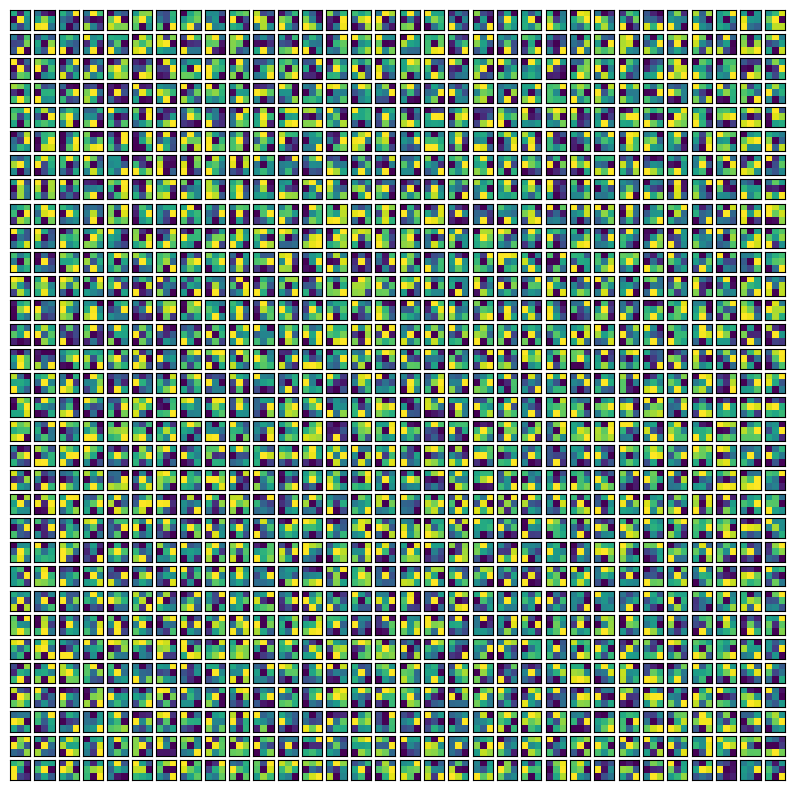

In [ ]:
visualize_filters(custom_model.layers[2])

In [ ]:
# ACTIVATIONS VISUALIZATION

def visualize_activations(model, layer, image, num_subplots):
    # Create a new model that outputs the activations for the chosen layer
    activation_model = Model(inputs=model.inputs, outputs=layer.output)

    # Get activations for the input image
    activations = activation_model.predict(image[np.newaxis, ...])

    # Number of filters in the chosen layer
    n_filters = activations.shape[-1]

    # Plot the original image
    plt.figure(figsize=(10, 10))
    plt.subplot(num_subplots, num_subplots, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')

    # Plot the activations
    for i in range(n_filters):
        ax = plt.subplot(num_subplots, num_subplots, i + 2)  # Adjust the index since the first subplot is the image
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.show()


1/1 [==============================] - 0s 55ms/step


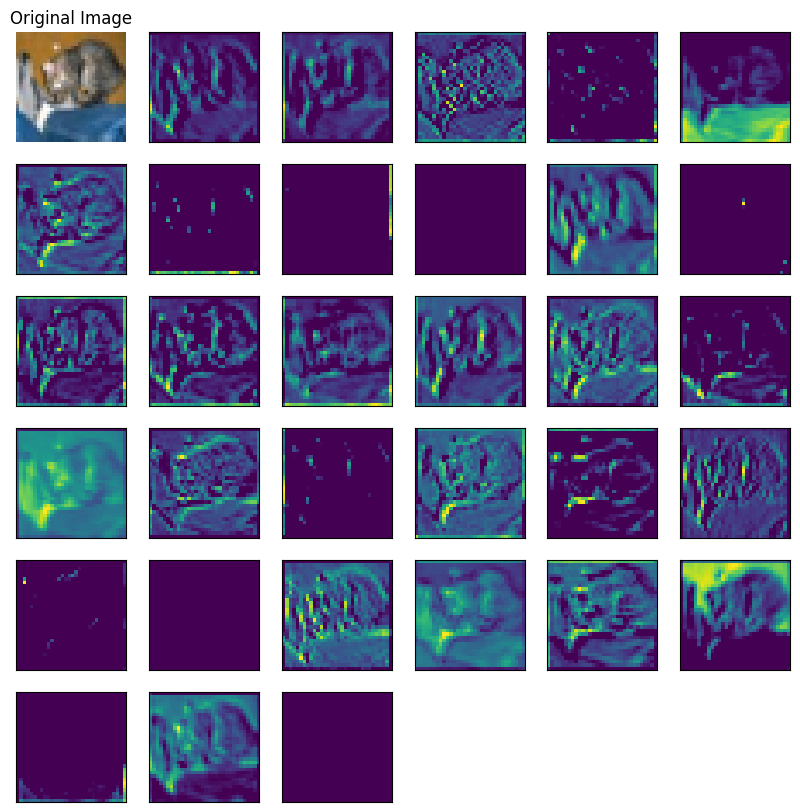

1/1 [==============================] - 0s 66ms/step


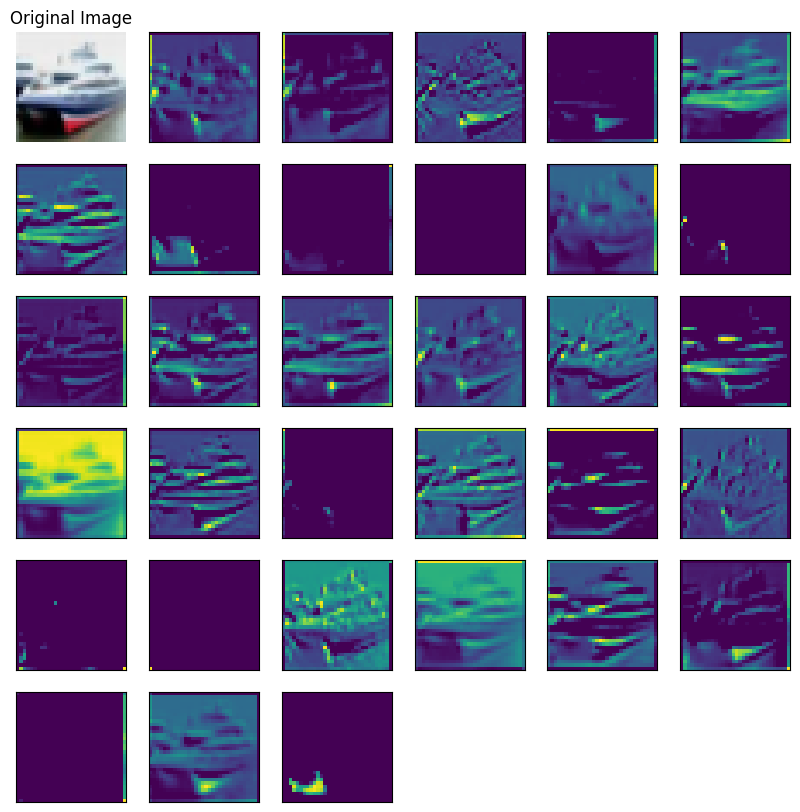

1/1 [==============================] - 0s 38ms/step


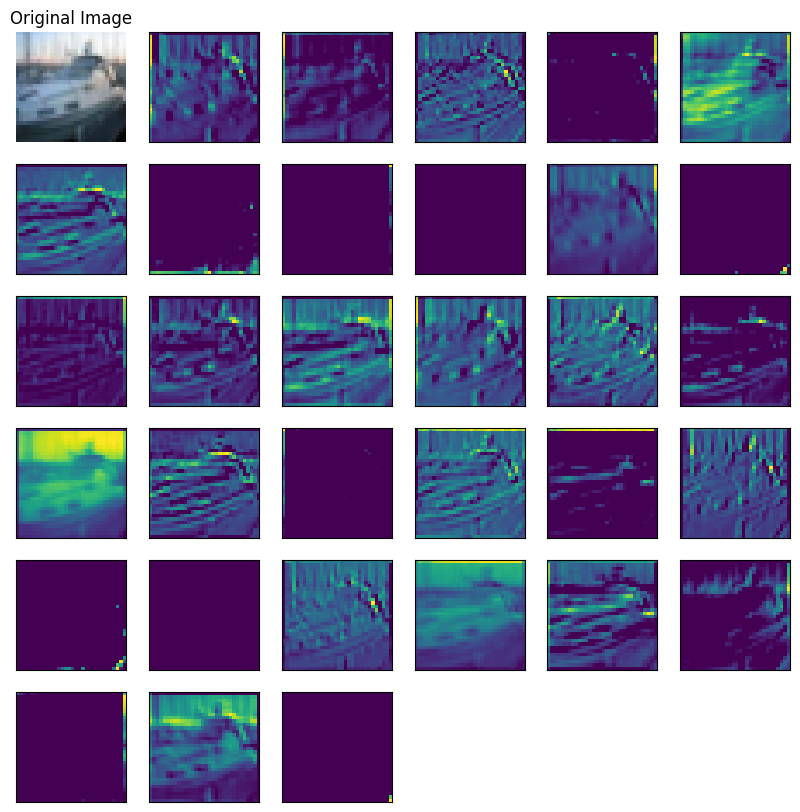

1/1 [==============================] - 0s 35ms/step


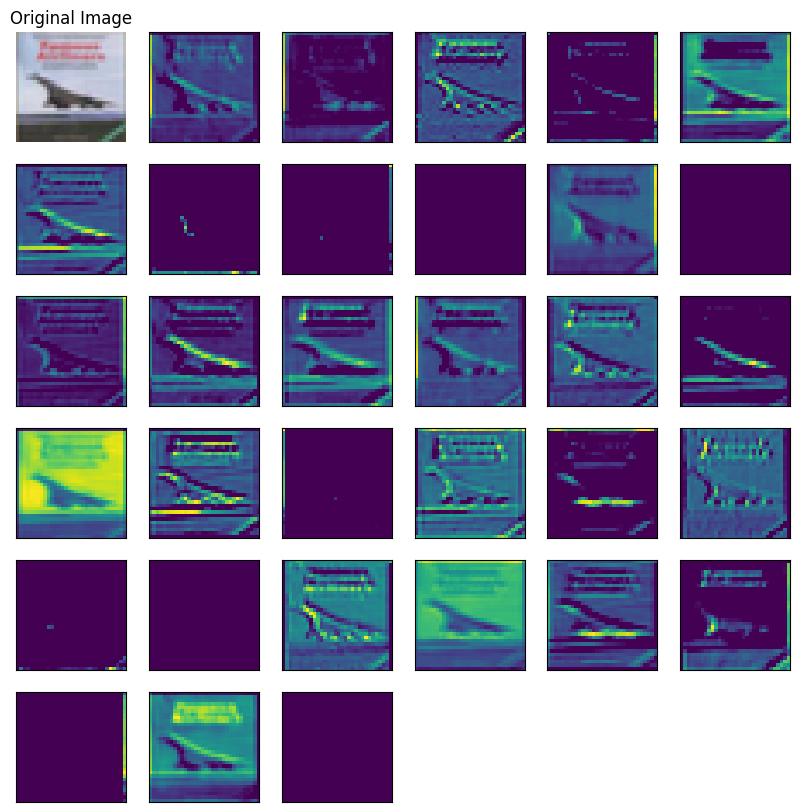

1/1 [==============================] - 0s 39ms/step


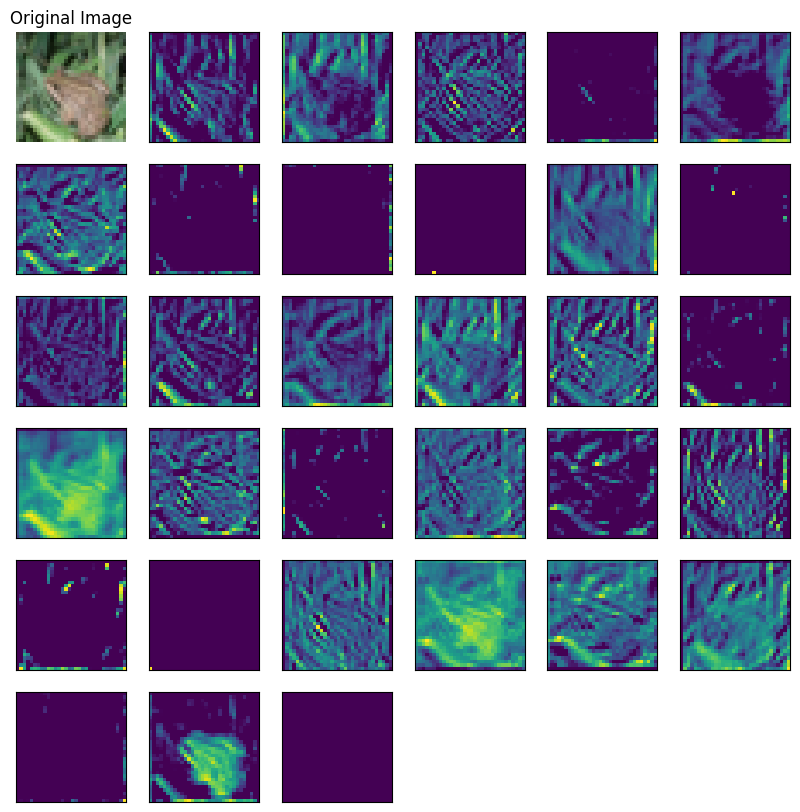

In [ ]:
chosen_layer = custom_model.layers[0]
num_subplots = int(np.ceil(np.sqrt(chosen_layer.output.shape[-1] + 1)))
for i in range(5):
    sample_image = test_data[i]
    visualize_activations(custom_model, chosen_layer, sample_image, num_subplots)


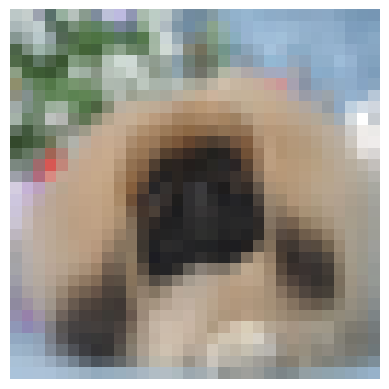

In [ ]:
sample_image = test_data[250]

if sample_image.shape[-1] == 3:
    # Scale the pixel values to the range 0-255
    scaled_image = np.clip(sample_image * 255, 0, 255).astype('uint8')

    # Display the image
    plt.imshow(scaled_image)
    plt.axis('off')  # Optional: to turn off the axis
    plt.show()
else:
    print("The image does not have 3 channels. Its shape is:", sample_image.shape)

In [ ]:
sample_image.shape

(32, 32, 3)

In [ ]:
for layer in custom_model.layers:
    print(layer.name)

conv2d
batch_normalization
conv2d_1
batch_normalization_1
max_pooling2d
dropout
conv2d_2
batch_normalization_2
conv2d_3
batch_normalization_3
max_pooling2d_1
dropout_1
conv2d_4
batch_normalization_4
conv2d_5
batch_normalization_5
max_pooling2d_2
dropout_2
flatten
dense
batch_normalization_6
dropout_3
dense_1


In [ ]:
import numpy as np
from keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def get_activations(model, layer_name, data):
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return intermediate_model.predict(data)

def sample_subset(data, labels, num_samples):
    idx = np.random.choice(len(data), num_samples, replace=False)
    return data[idx], labels[idx]

def tsne_plot_activations(activations, labels, class_names):
    # Convert one-hot encoded labels to class indices if necessary
    if labels.ndim > 1:
        labels = np.argmax(labels, axis=1)

    # Ensure activations is a 2D array: (samples, features)
    if activations.ndim > 2:
        activations = activations.reshape(activations.shape[0], -1)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    tsne_results = tsne.fit_transform(activations)

    # Plot
    plt.figure(figsize=(10, 10))
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    for i, label in enumerate(unique_labels):
        plt.scatter(tsne_results[labels == label, 0], tsne_results[labels == label, 1],
                    color=colors[i], label=class_names[label])

    plt.legend(title='Labels')
    plt.show()

Processing layer: dense
32/32 [==============================] - 2s 10ms/step


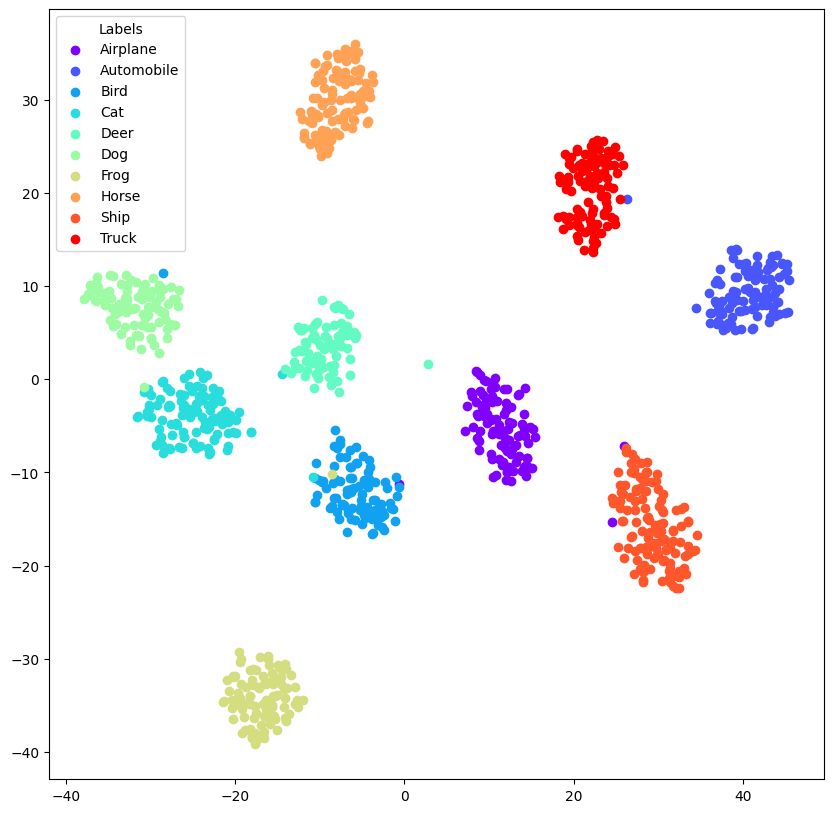

Processing layer: dense_1
32/32 [==============================] - 0s 3ms/step


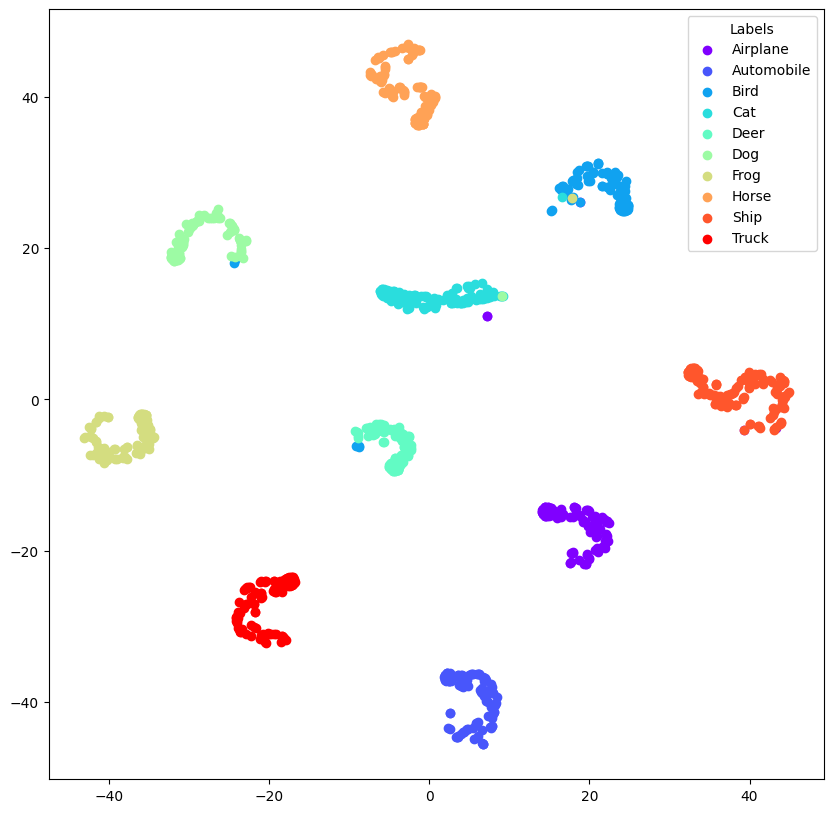

In [ ]:
# Define CIFAR-10 class names
cifar10_class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
                       "Dog", "Frog", "Horse", "Ship", "Truck"]

# Sample a subset of your data
num_samples = 1000  # Adjust this number based on your RAM capacity
subset_data, subset_labels = sample_subset(train_data, train_labels, num_samples)

for layer in custom_model.layers:
    if 'dense' in layer.name:  # Check if the layer is a Dense layer
        print(f"Processing layer: {layer.name}")
        # Get activations for the subset
        activations = get_activations(custom_model, layer.name, subset_data)
        # t-SNE plot for the current layer
        tsne_plot_activations(activations, subset_labels, cifar10_class_names)

In [ ]:
from keras.models import Model
import numpy as np

def get_top_k_activations_per_unit(model, layer_name, data, k=10, batch_size=1024):
    # Get the output shape of the specified layer
    num_units = model.get_layer(layer_name).output_shape[-1]

    # Initialize dictionaries to store top k indices and activations for each unit
    top_k_indices_per_unit = {f"unit{i}": np.zeros(k, dtype=int) for i in range(num_units)}
    top_k_activations_per_unit = {f"unit{i}": np.zeros(k) for i in range(num_units)}

    # Create an intermediate model to get activations from the specified layer
    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        activations = intermediate_model.predict(batch)

        # Flatten activations if they are from a conv layer
        if activations.ndim == 4:
            activations = activations.reshape(activations.shape[0], -1)

        for unit in range(num_units):
            unit_activations = activations[:, unit]
            sorted_indices = np.argsort(unit_activations)[-k:]

            for rank, idx in enumerate(sorted_indices):
                global_idx = i + idx
                current_activation = unit_activations[idx]

                # Update the top k list if current activation is higher
                if current_activation > top_k_activations_per_unit[f"unit{unit}"][rank]:
                    top_k_activations_per_unit[f"unit{unit}"][rank] = current_activation
                    top_k_indices_per_unit[f"unit{unit}"][rank] = global_idx

    # Sorting each unit's top k indices by activation value
    for unit in top_k_indices_per_unit:
        sorted_indices = np.argsort(-top_k_activations_per_unit[unit])  # Negative for descending sort
        top_k_indices_per_unit[unit] = top_k_indices_per_unit[unit][sorted_indices]

    return top_k_indices_per_unit


In [ ]:
top_k_indices = get_top_k_activations_per_unit(custom_model, "conv2d", train_data)

27/27 [==============================] - 0s 4ms/step


In [ ]:
def plot_top_k_images(data, top_k_indices_dict, k=10):
    # Number of units is the length of the dictionary keys
    num_units = len(top_k_indices_dict)

    fig, axes = plt.subplots(k, num_units, figsize=(num_units * 2, k * 2))

    for unit_idx, (unit, img_indices) in enumerate(top_k_indices_dict.items()):
        for img_rank, img_idx in enumerate(img_indices):
            if img_rank < k:  # Check in case there are less than k images
                img = data[img_idx]
                if num_units > 1:  # Multiple units
                    ax = axes[img_rank, unit_idx]
                else:  # Single unit
                    ax = axes[img_rank]
                ax.imshow(img)
                ax.axis('off')
                if img_rank == 0:
                    ax.set_title(f"Unit {unit_idx}")

    plt.tight_layout()
    plt.show()


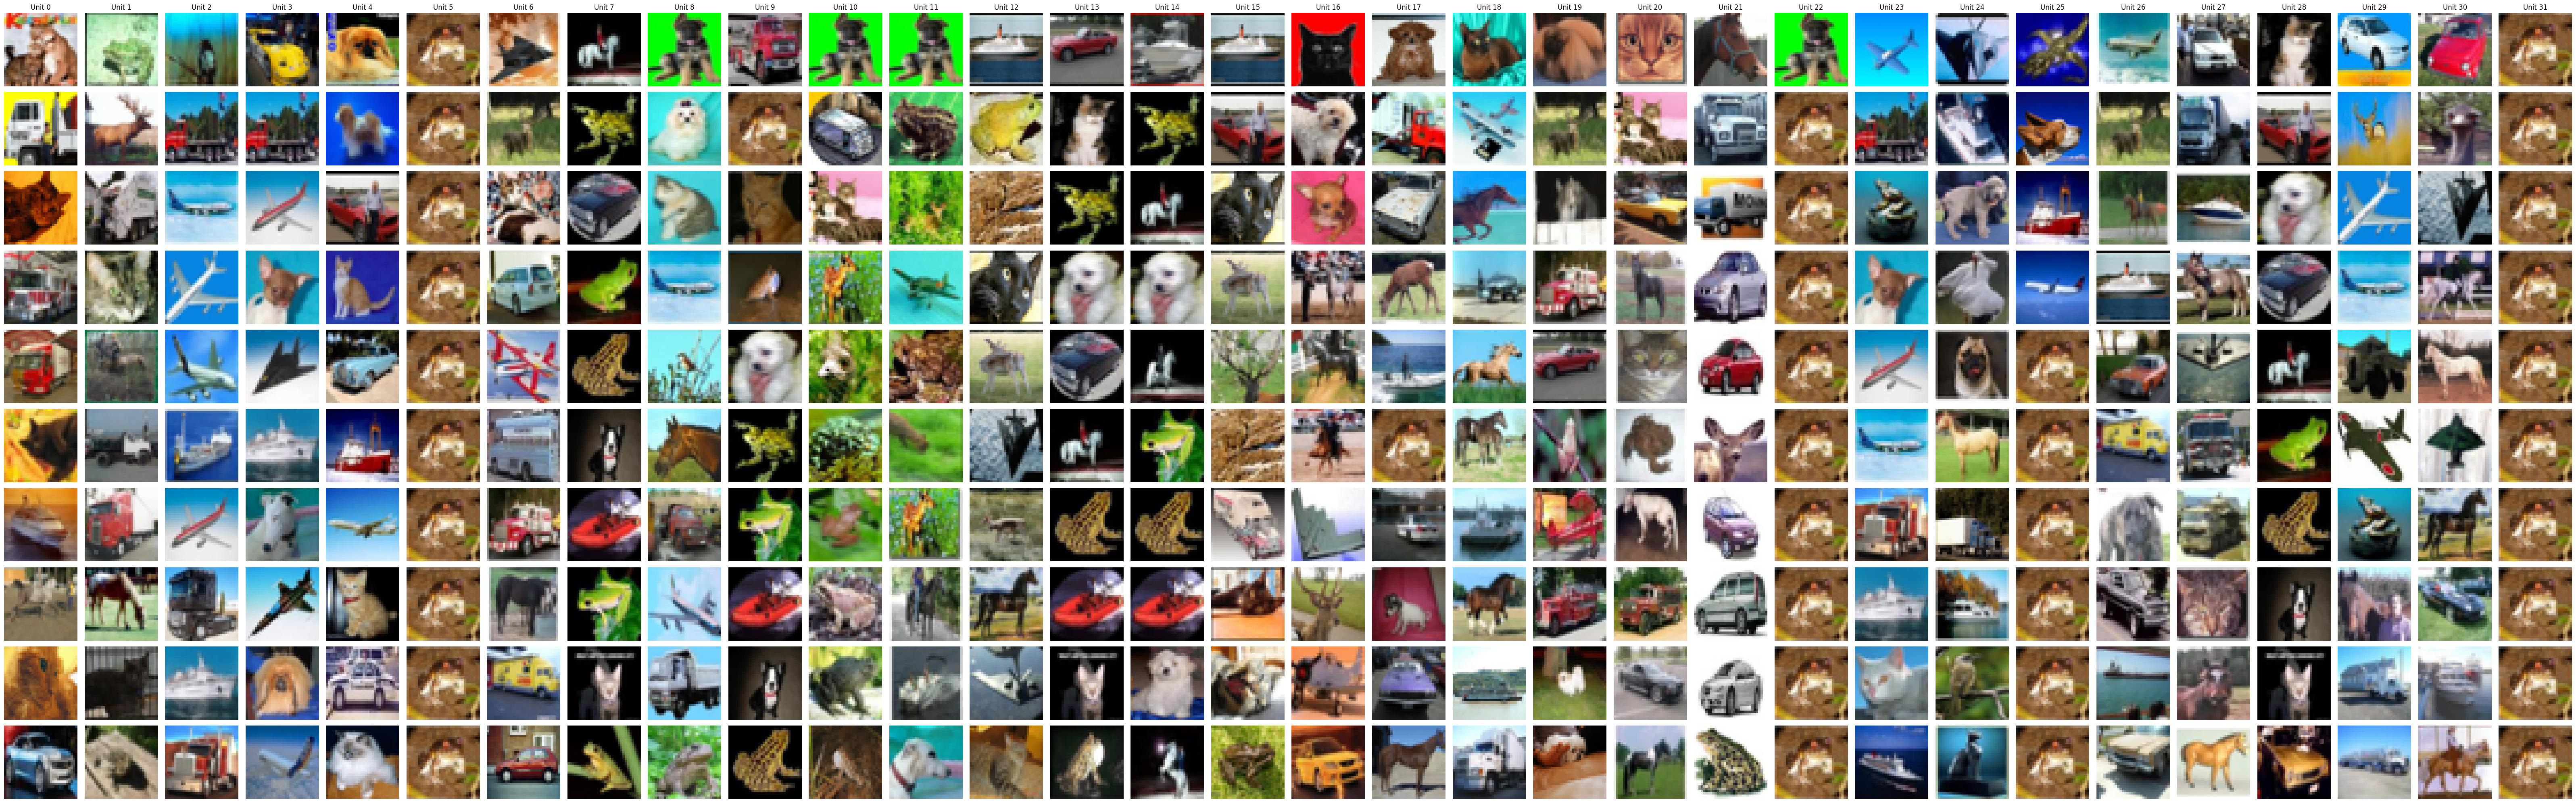

In [ ]:
plot_top_k_images(train_data, top_k_indices)

In [ ]:
top_k_indices

{'unit0': array([27298, 49823, 25627, 17535, 27420, 27467, 27243, 26858, 27142,
        27194]),
 'unit1': array([48049, 30794, 43016, 43084, 43694, 43104, 24693, 43587, 43018,
        31396]),
 'unit2': array([14135, 25506,  4202,  4239,  4229, 24608, 25261, 25010, 24588,
        25510]),
 'unit3': array([32913, 25506, 25261, 24585, 24685, 24588, 24890, 25110, 25157,
        24581]),
 'unit4': array([ 3367, 27289,  7288,  7566, 15447, 15698, 16213, 48494, 13006,
        18619]),
 'unit5': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'unit6': array([40159, 47305, 36738, 47264, 47906, 47238, 47124, 48029,  7210,
        16997]),
 'unit7': array([2814, 2439, 2143, 2356,  588,  198,  958,  104, 2412, 2226]),
 'unit8': array([40154, 18568, 45454,  4202, 11731,  4582, 12245, 12165, 46955,
          896]),
 'unit9': array([43384,     0,   895,   682,  2316,  2439,   104,   958,   198,
          588]),
 'unit10': array([40154, 49785, 48933,  1005,   649,   899,   473, 25291, 24886,
        25358])

### VGG16 MODEL

In [ ]:
# load pretrained VGG16 model from tensorflow
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


In [ ]:
vgg16_model.layers

1/1 [==============================] - 0s 121ms/step


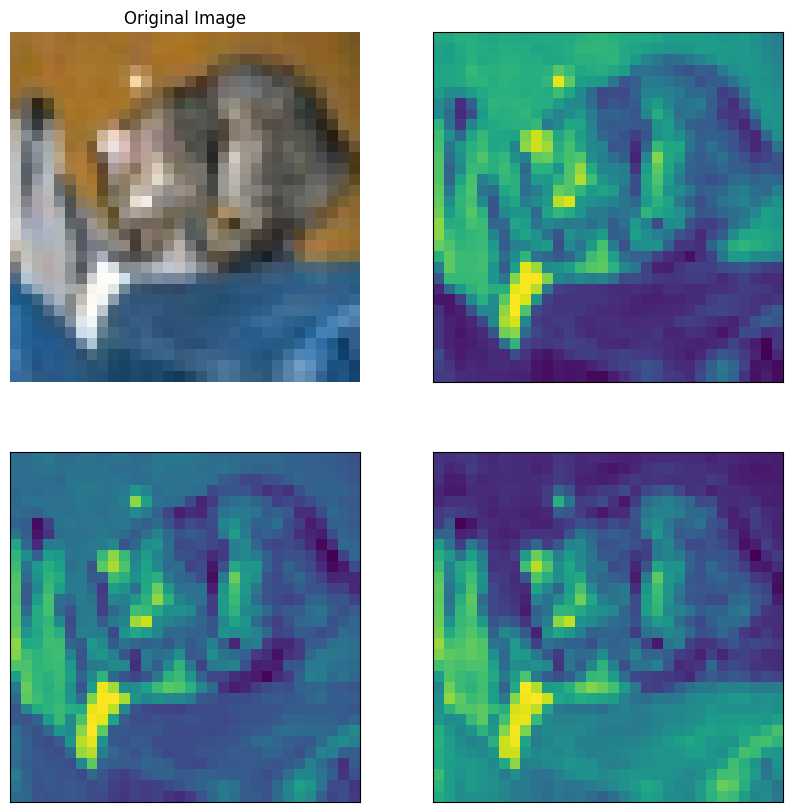

1/1 [==============================] - 0s 48ms/step


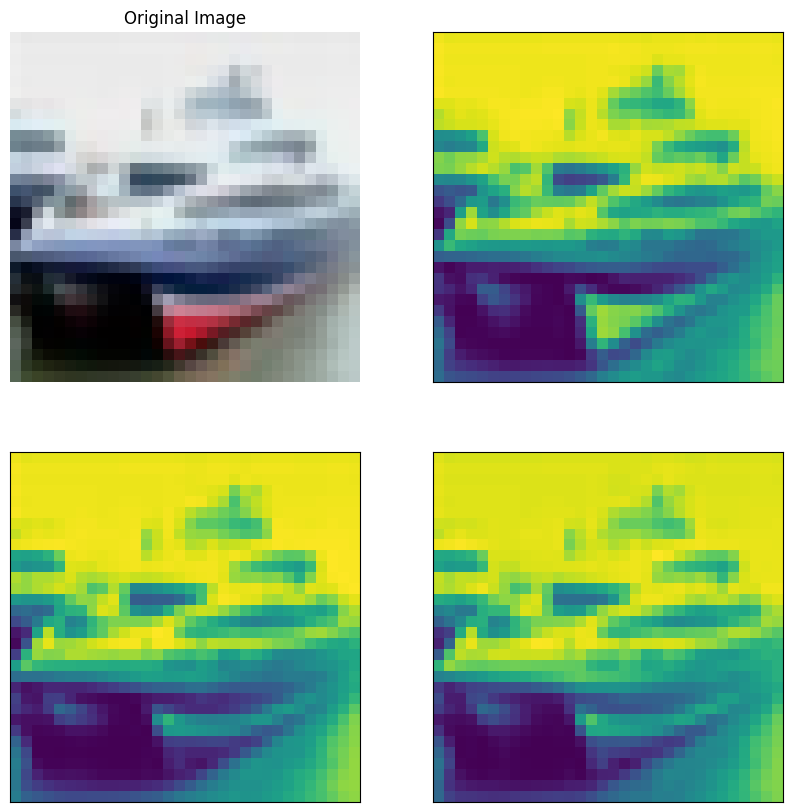

1/1 [==============================] - 0s 146ms/step


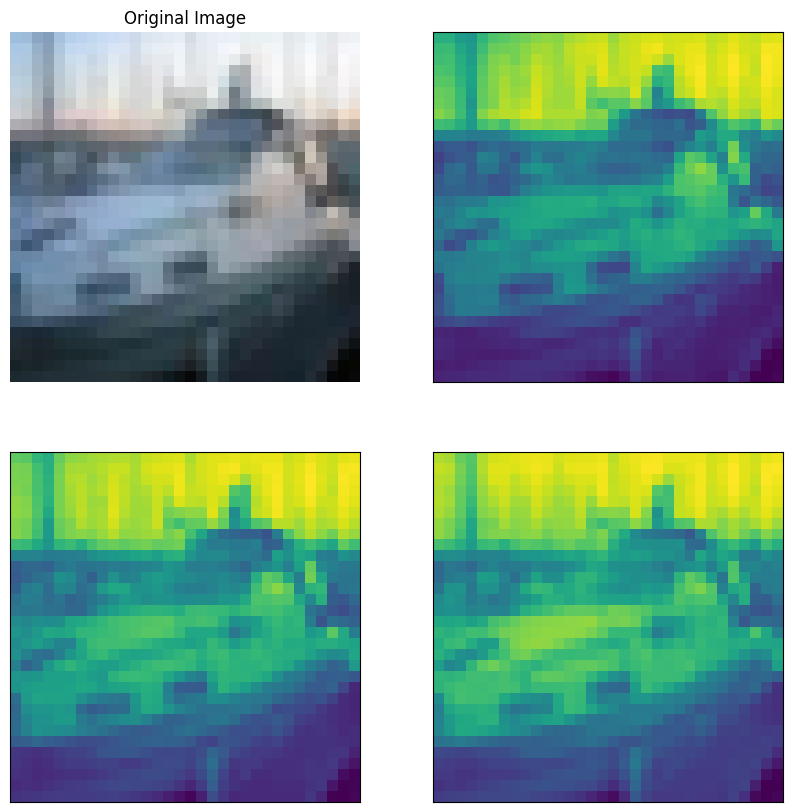

1/1 [==============================] - 0s 59ms/step


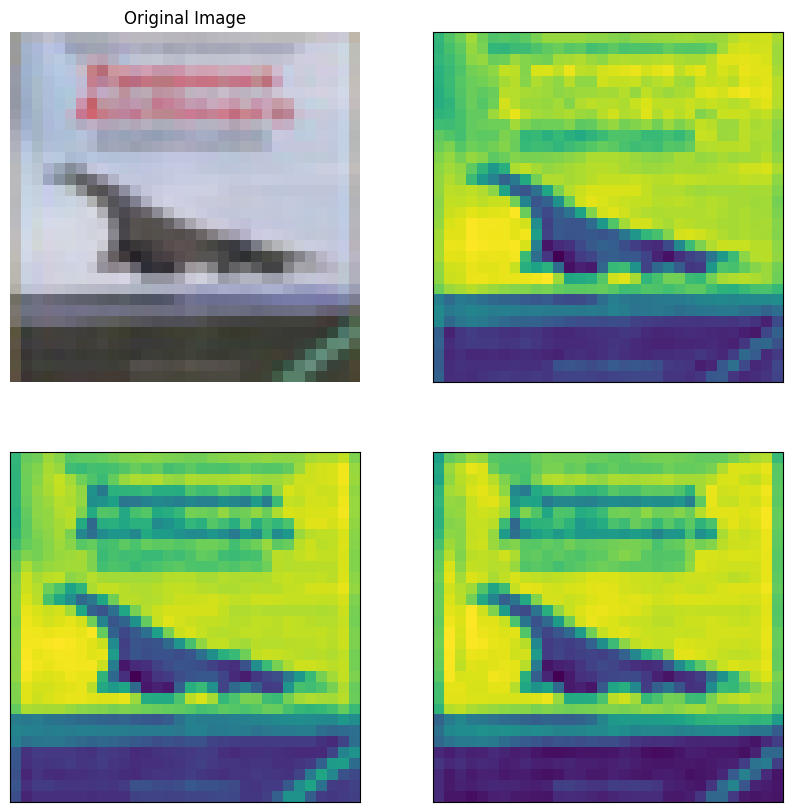

1/1 [==============================] - 0s 31ms/step


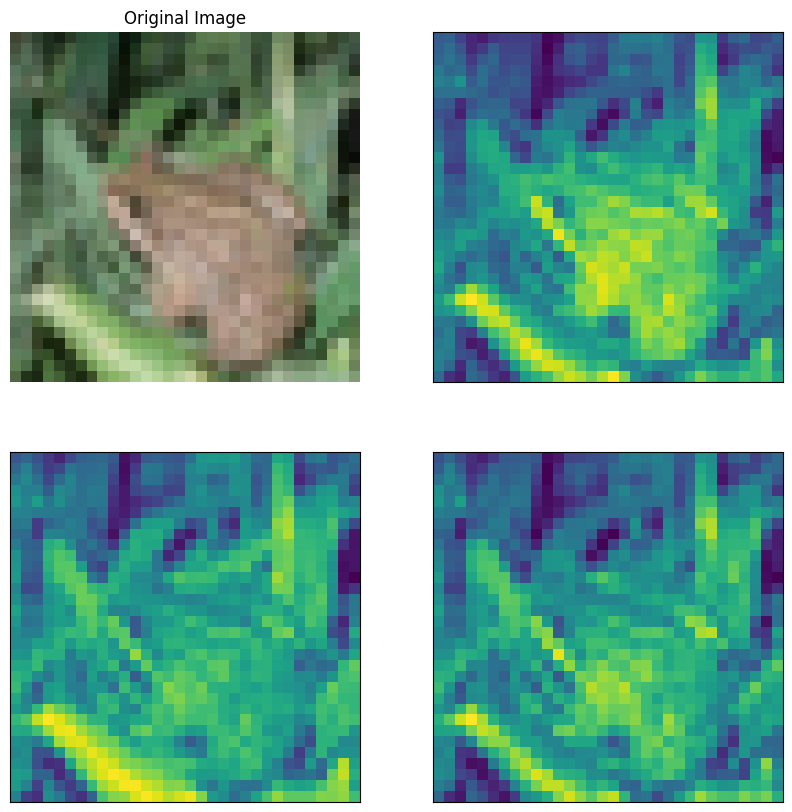

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img


chosen_layer = vgg16_model.layers[0]
num_subplots = int(np.ceil(np.sqrt(chosen_layer.output.shape[-1] + 1)))
for i in range(5):
    sample_image = test_data[i]
    visualize_activations(vgg16_model, chosen_layer, sample_image, num_subplots)


1/1 [==============================] - 3s 3s/step


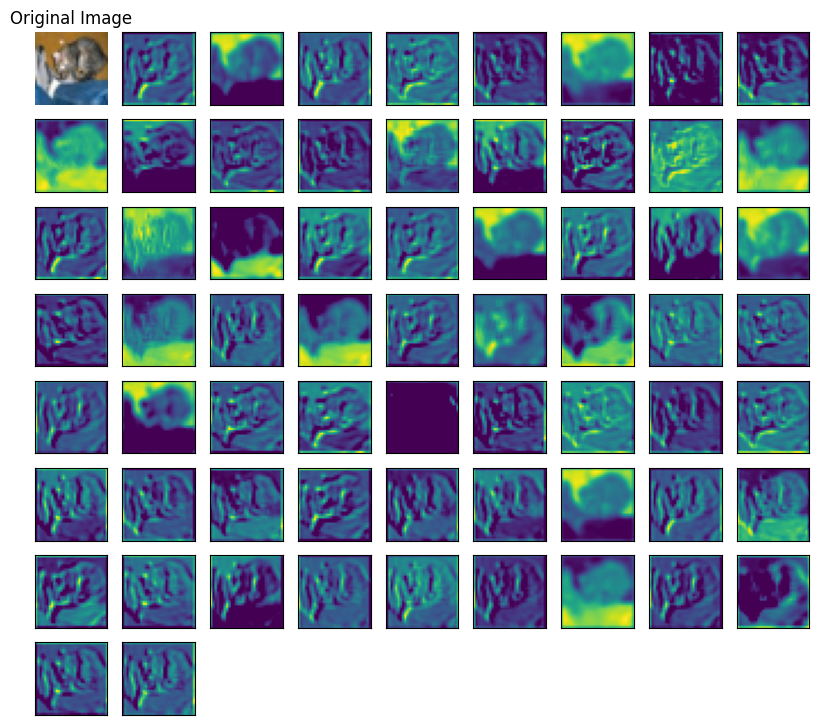

1/1 [==============================] - 0s 50ms/step


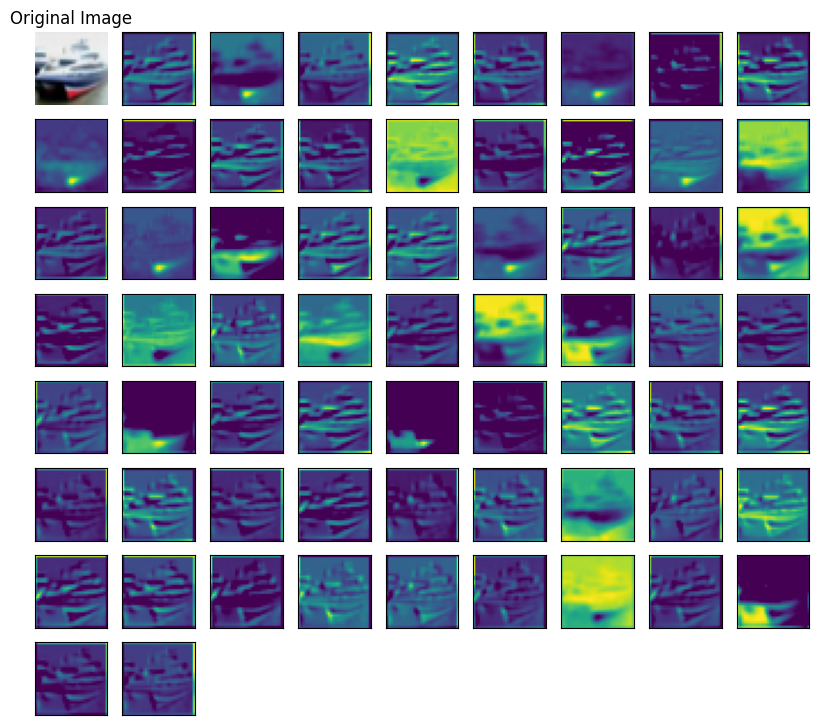

1/1 [==============================] - 0s 58ms/step


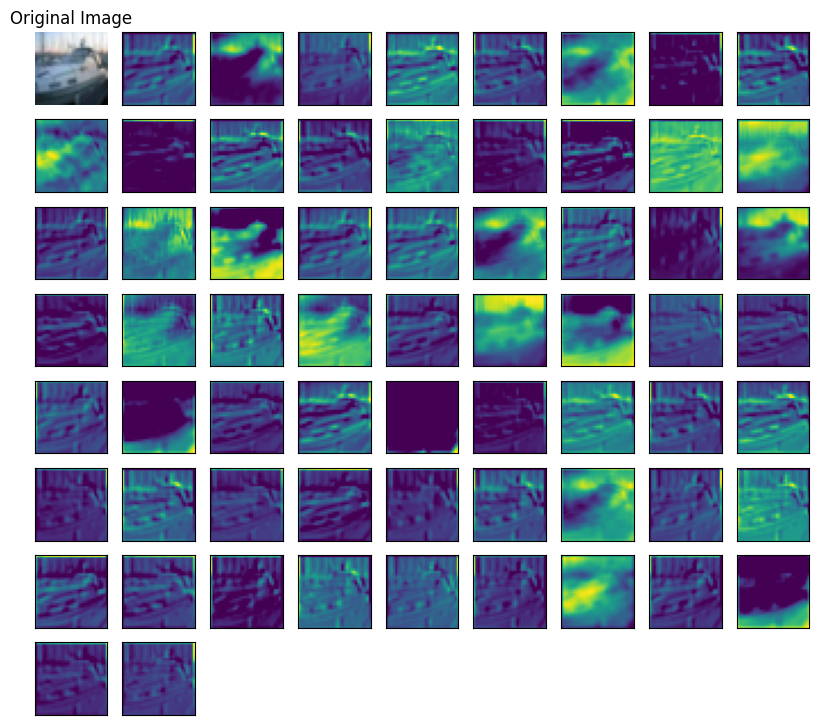

1/1 [==============================] - 0s 57ms/step


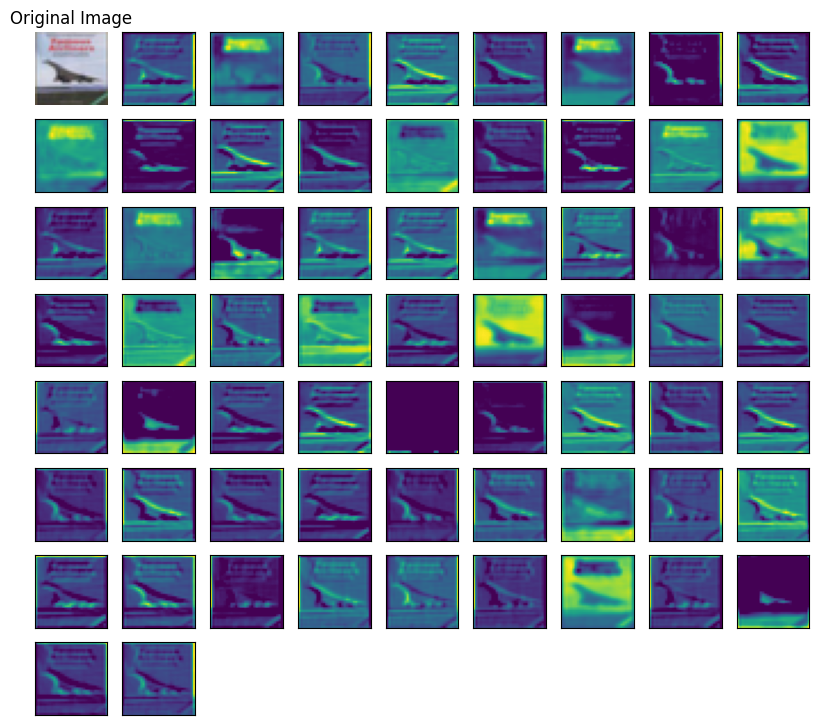

1/1 [==============================] - 0s 55ms/step


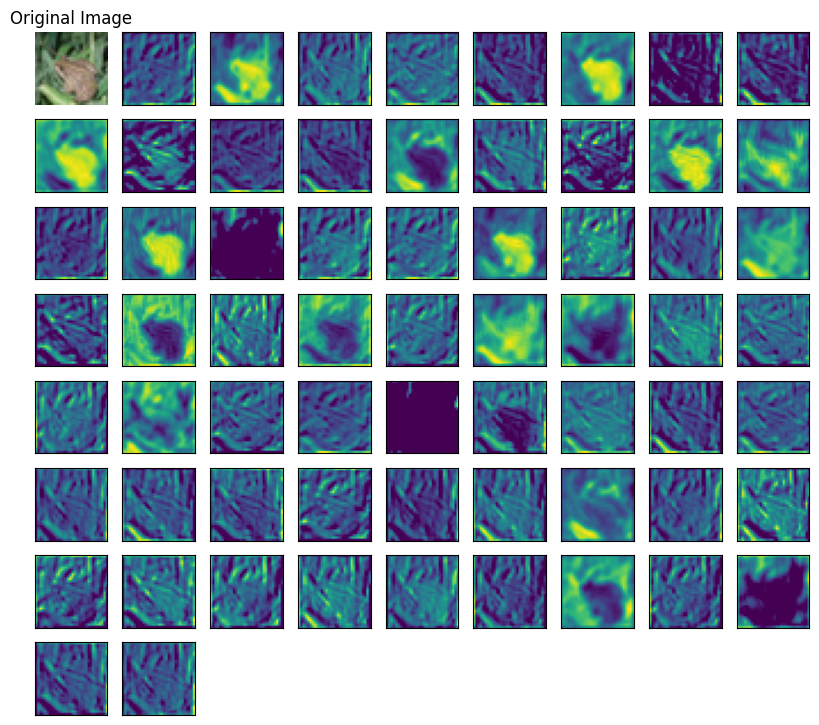

In [ ]:
chosen_layer = vgg16_model.layers[1]
num_subplots = int(np.ceil(np.sqrt(chosen_layer.output.shape[-1] + 1)))
for i in range(5):
    sample_image = test_data[i]
    visualize_activations(vgg16_model, chosen_layer, sample_image, num_subplots)

1/1 [==============================] - 2s 2s/step


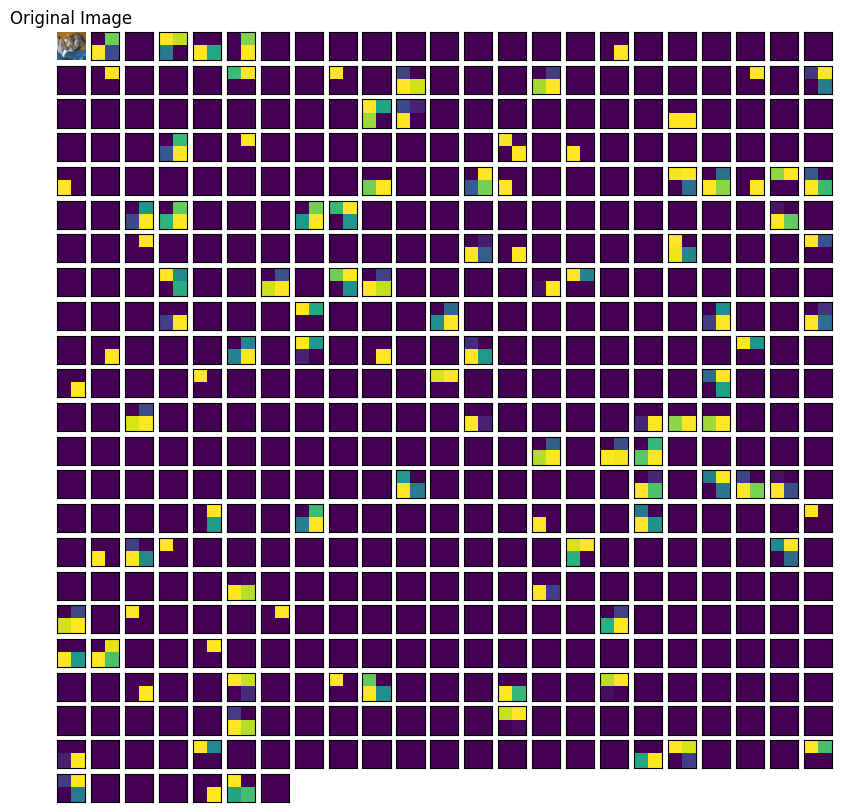

1/1 [==============================] - 0s 252ms/step


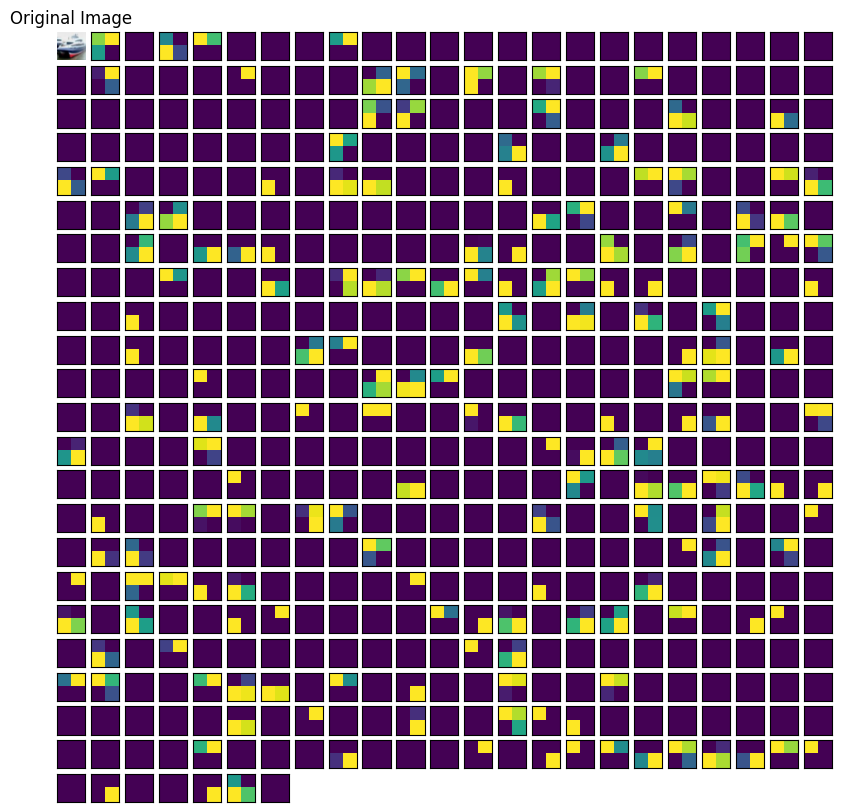

1/1 [==============================] - 0s 189ms/step


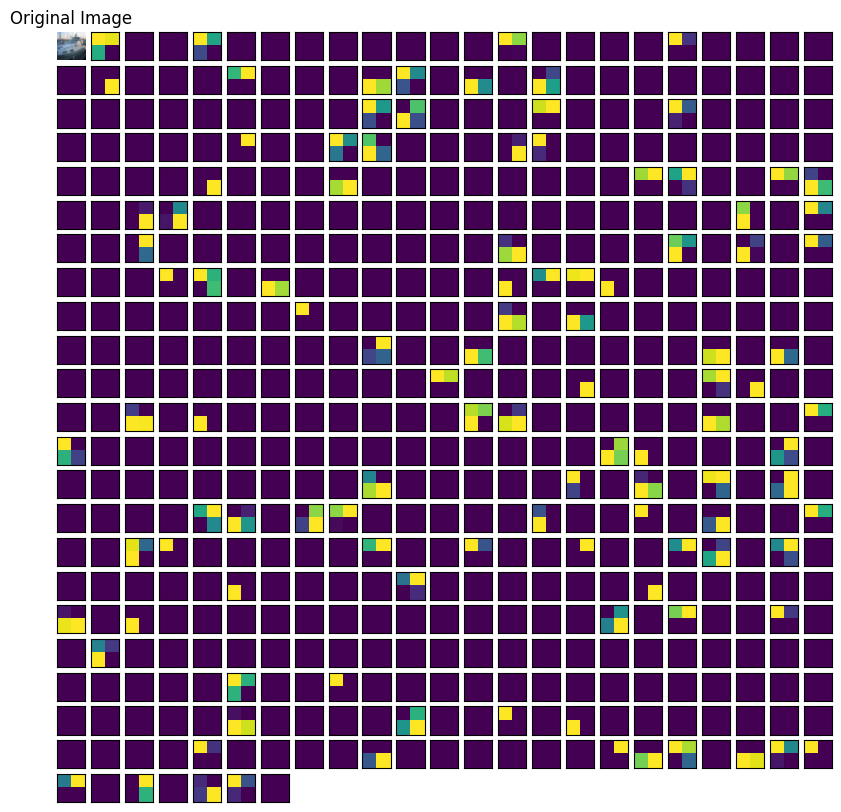

1/1 [==============================] - 0s 138ms/step


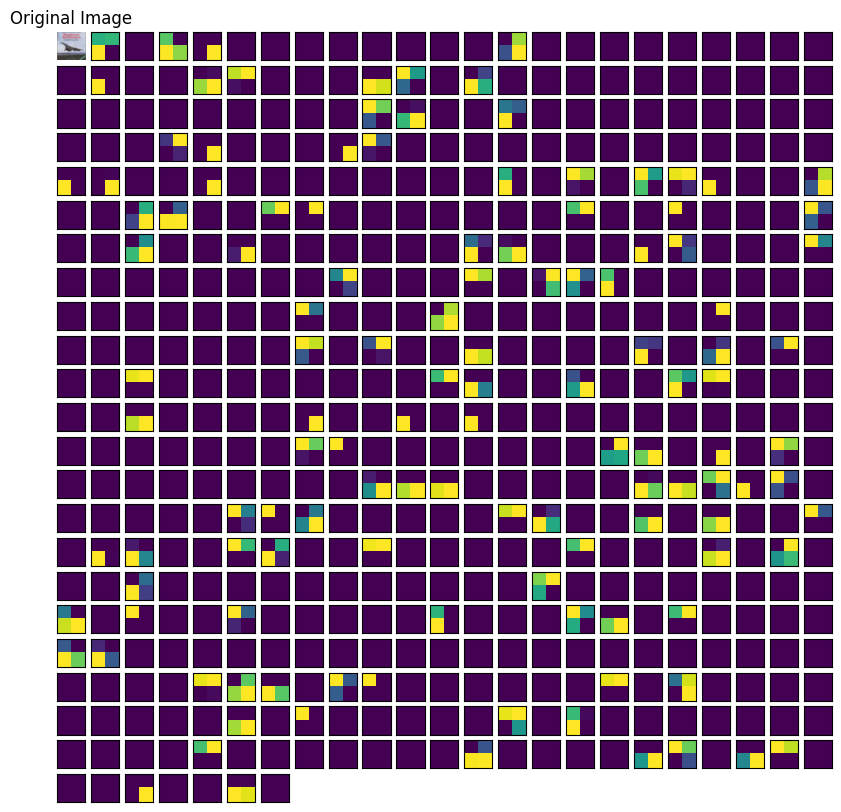

1/1 [==============================] - 0s 193ms/step


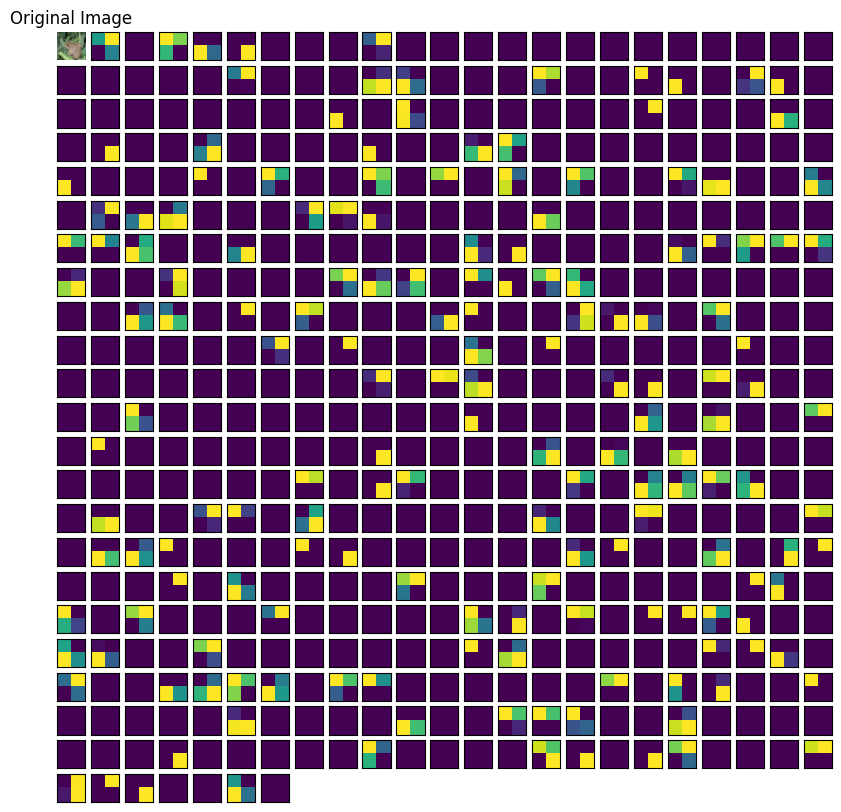

In [ ]:
chosen_layer = vgg16_model.layers[17]
num_subplots = int(np.ceil(np.sqrt(chosen_layer.output.shape[-1] + 1)))
for i in range(5):
    sample_image = test_data[i]
    visualize_activations(vgg16_model, chosen_layer, sample_image, num_subplots)

In [ ]:
[layer.name for layer in vgg16_model.layers]

['input_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool']

In [ ]:
top_k_indices = get_top_k_activations_per_unit(vgg16_model, "block1_conv2", train_data, 10)

27/27 [==============================] - 0s 6ms/step


In [ ]:
def plot_top_k_images_per_unit(data, top_k_indices_dict, k=10):
    for unit_idx, (unit, img_indices) in enumerate(top_k_indices_dict.items()):
        # Create a new figure for each unit
        fig, axes = plt.subplots(1, k, figsize=(k * 2, 2))

        for img_rank, img_idx in enumerate(img_indices):
            if img_rank < k:  # Check in case there are less than k images
                img = data[img_idx]
                ax = axes[img_rank] if k > 1 else axes
                ax.imshow(img)
                ax.axis('off')
                if img_rank == 0:
                    ax.set_title(f"Unit {unit_idx}")

        plt.tight_layout()
        plt.show()

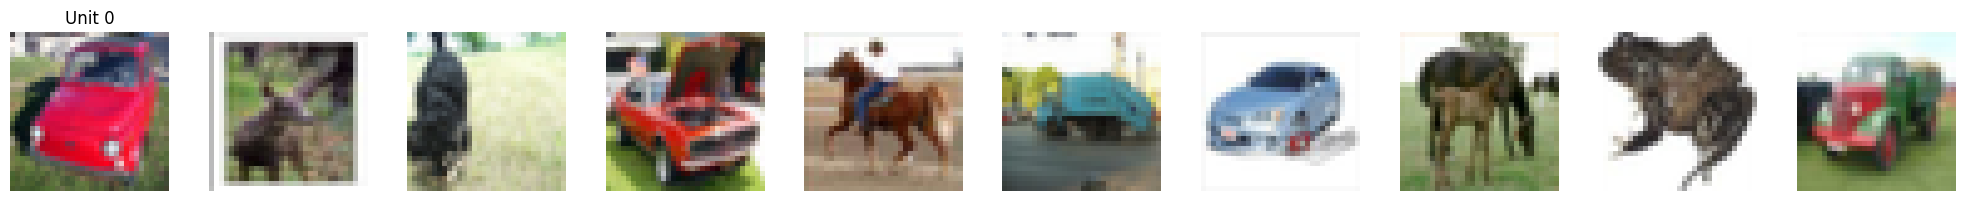

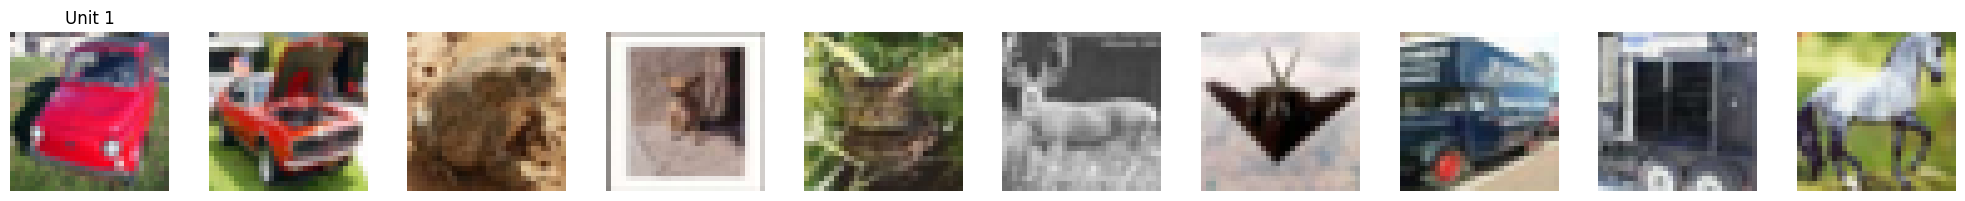

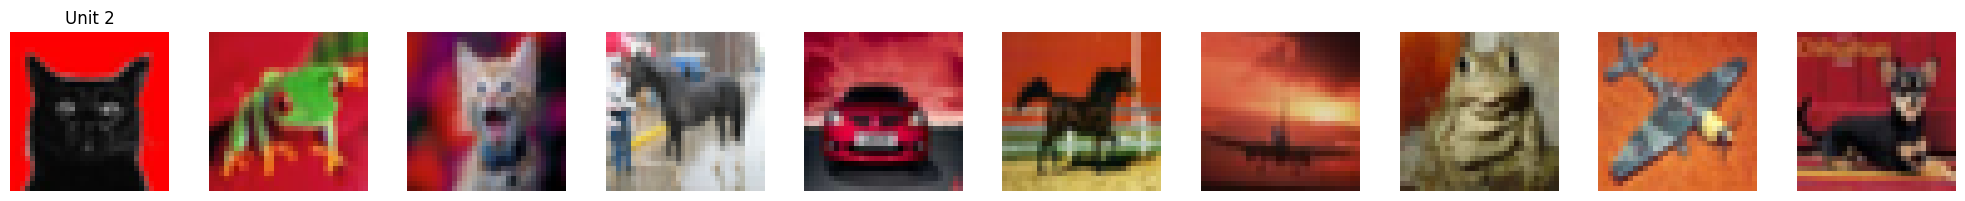

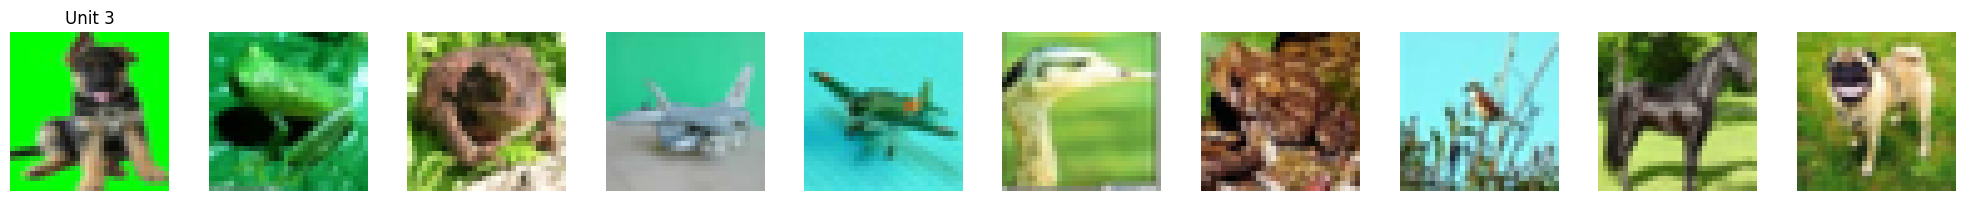

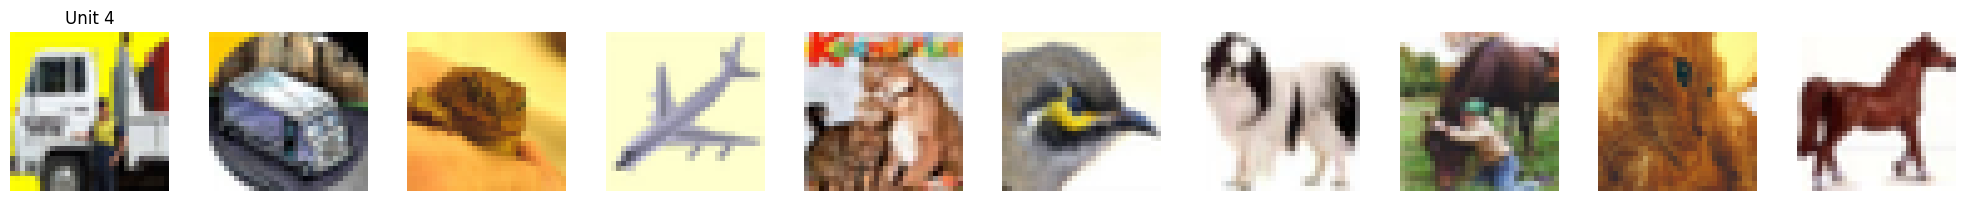

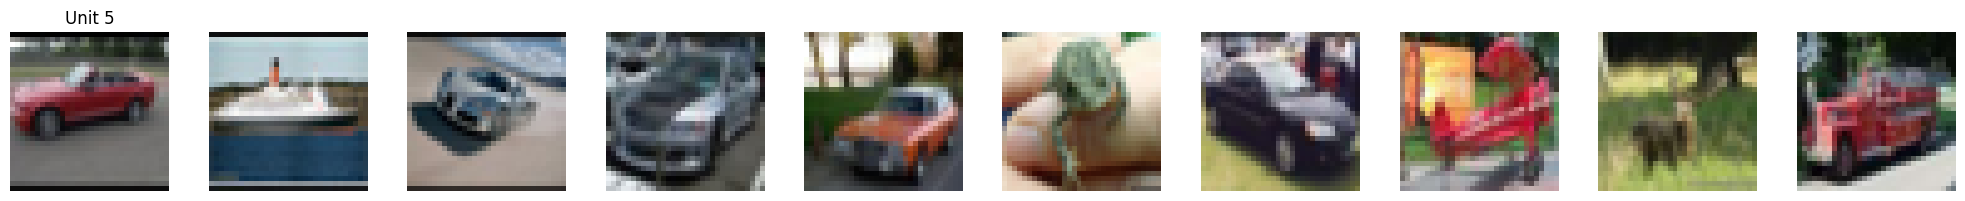

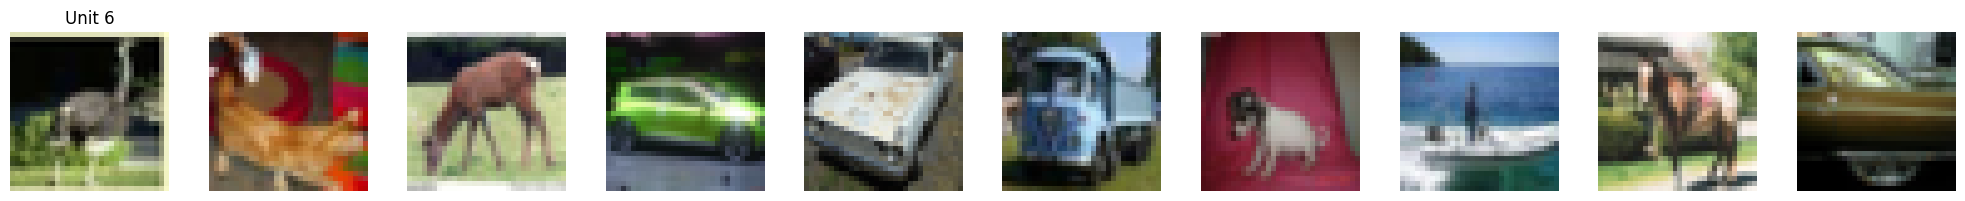

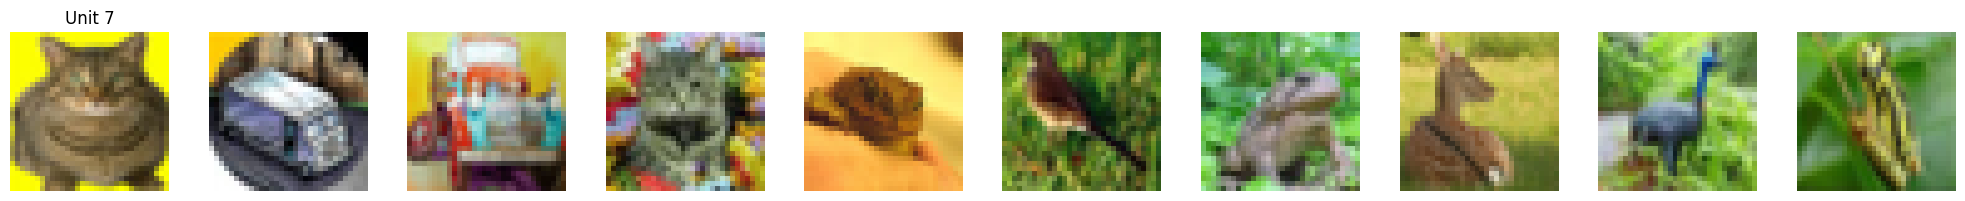

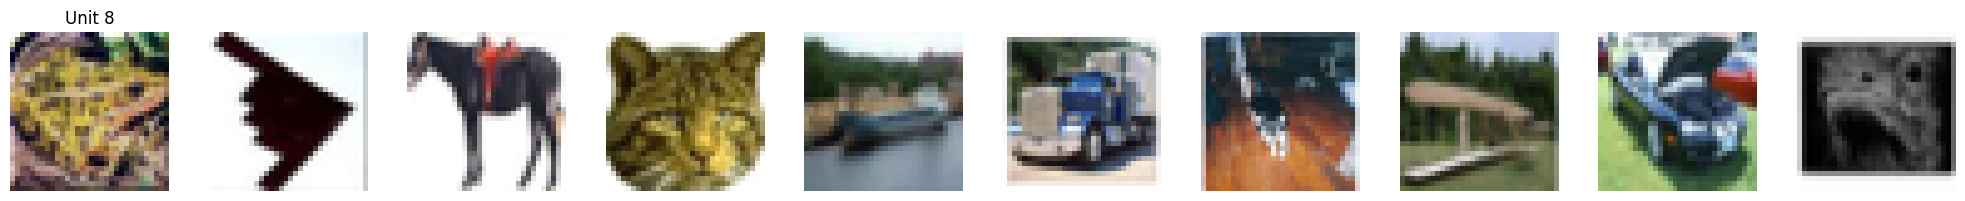

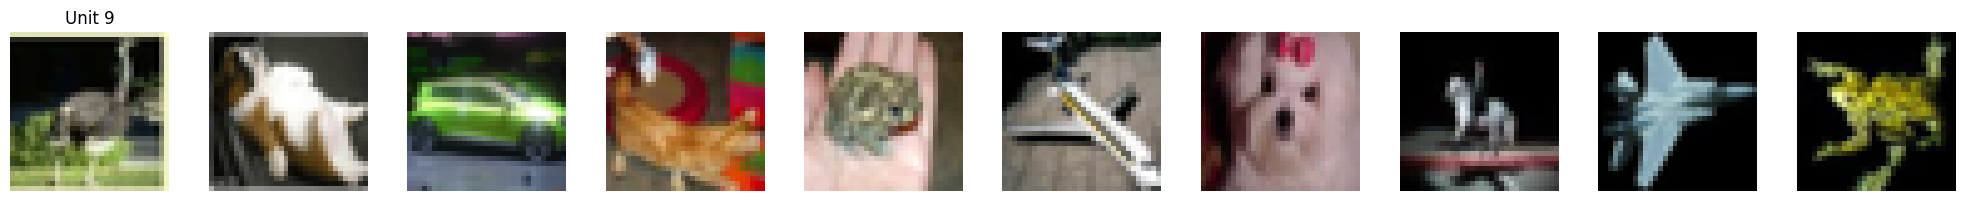

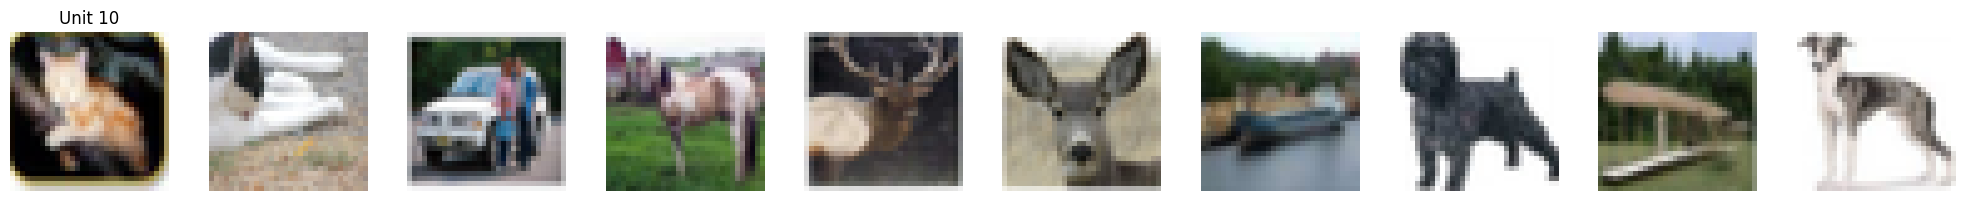

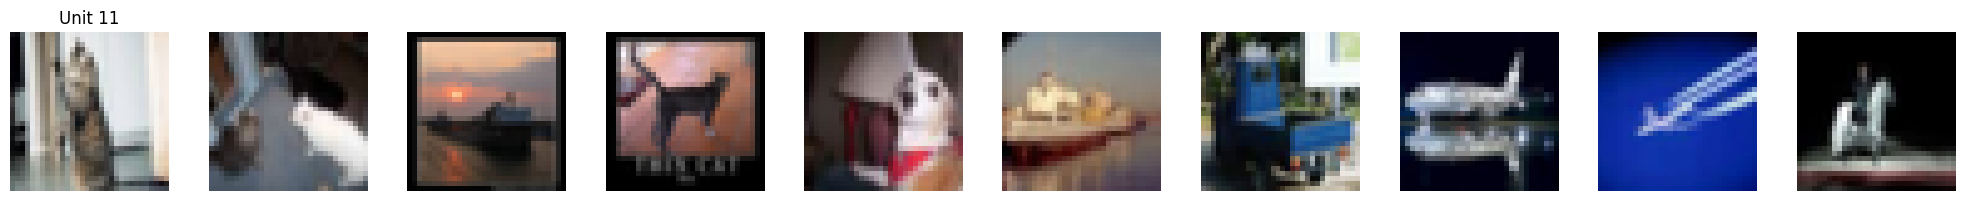

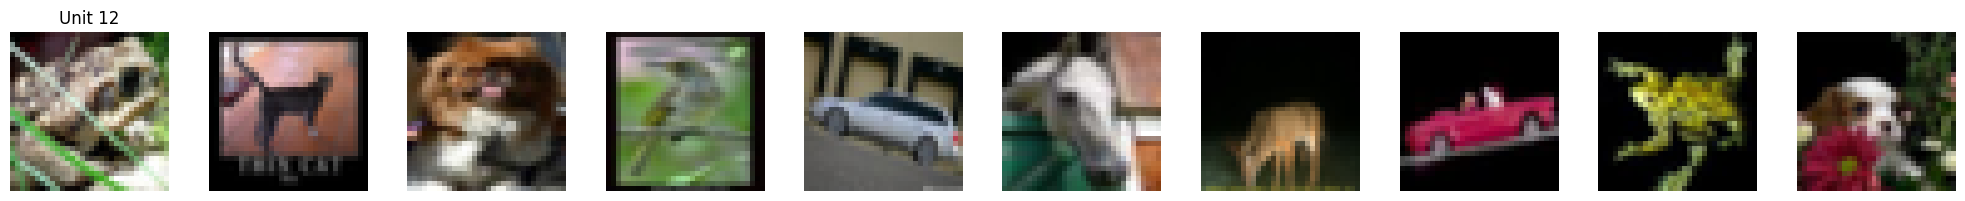

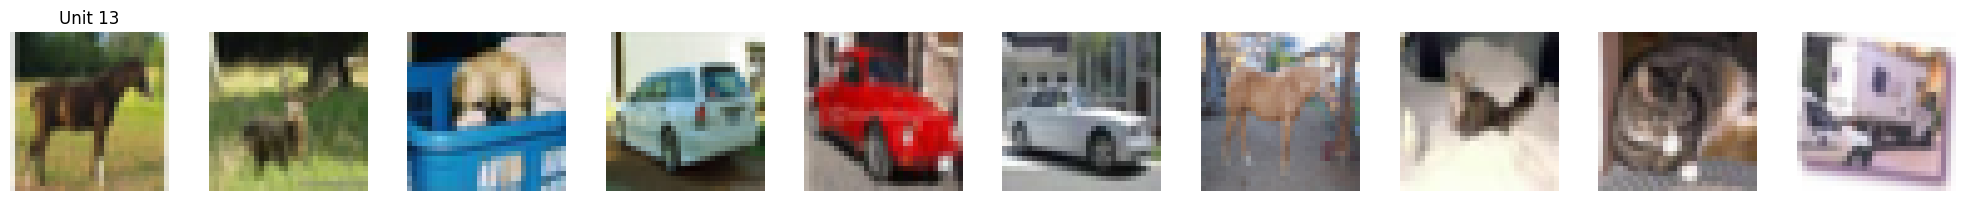

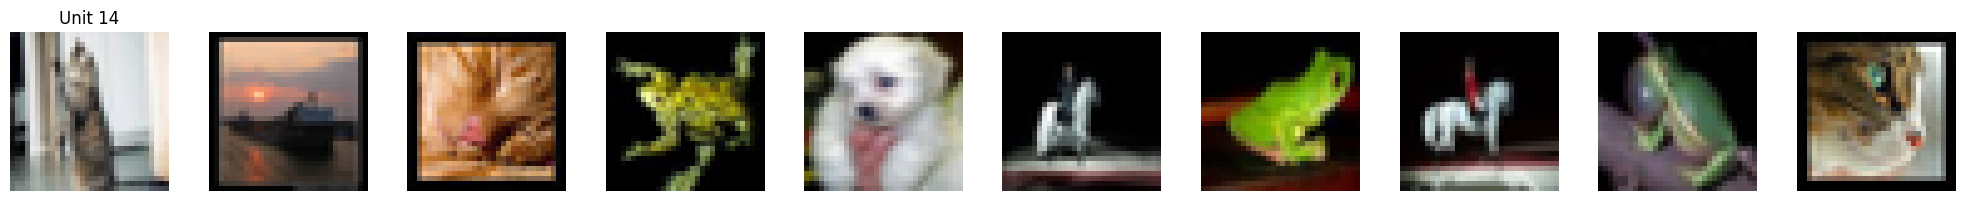

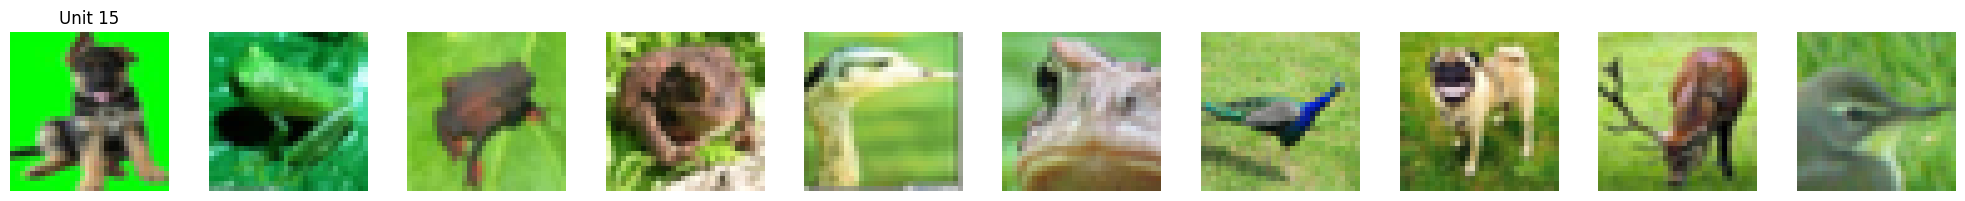

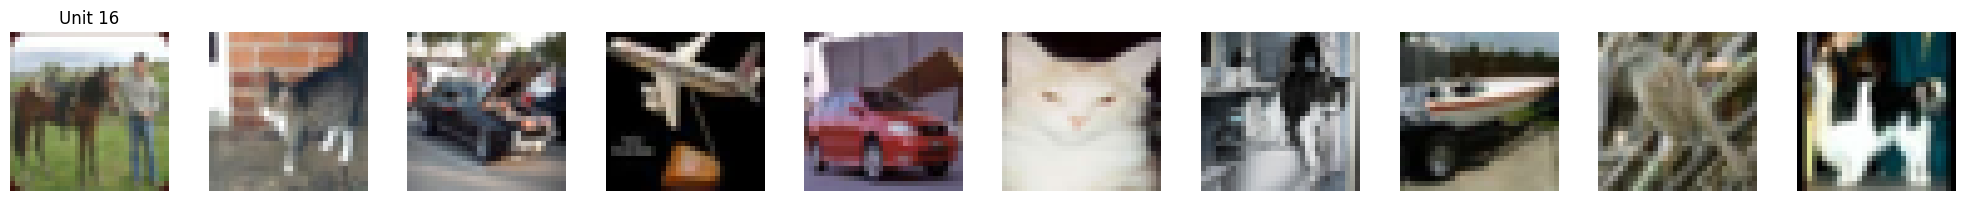

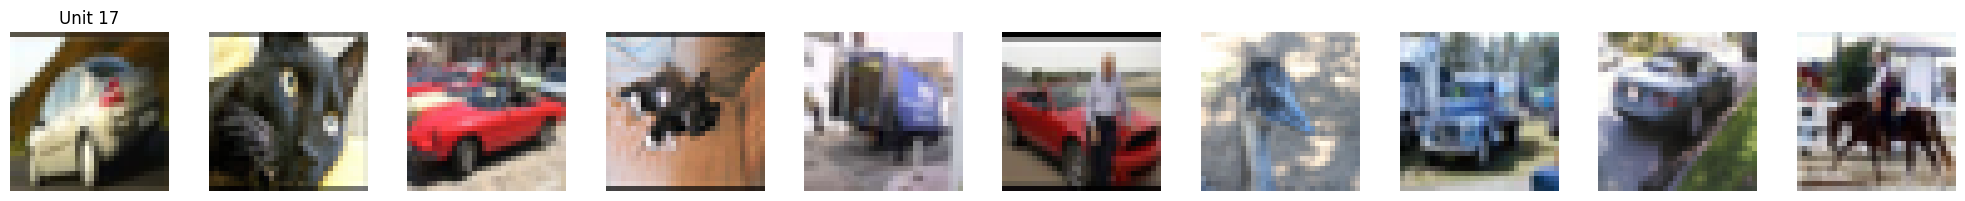

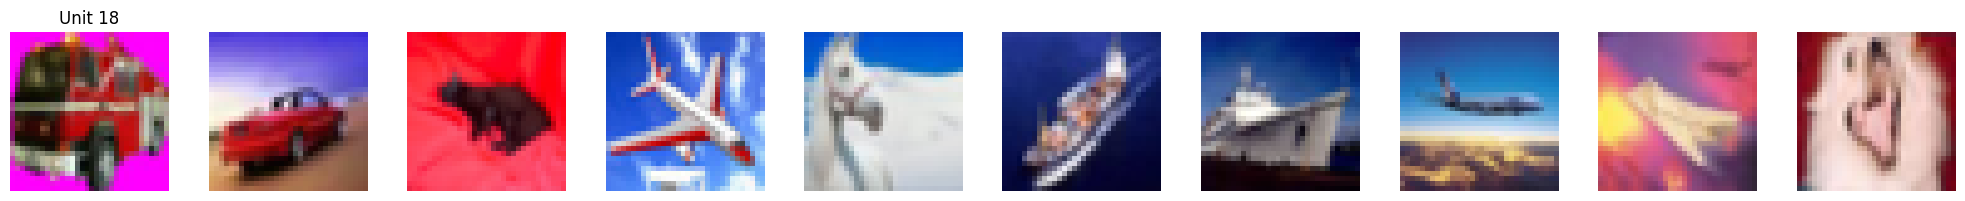

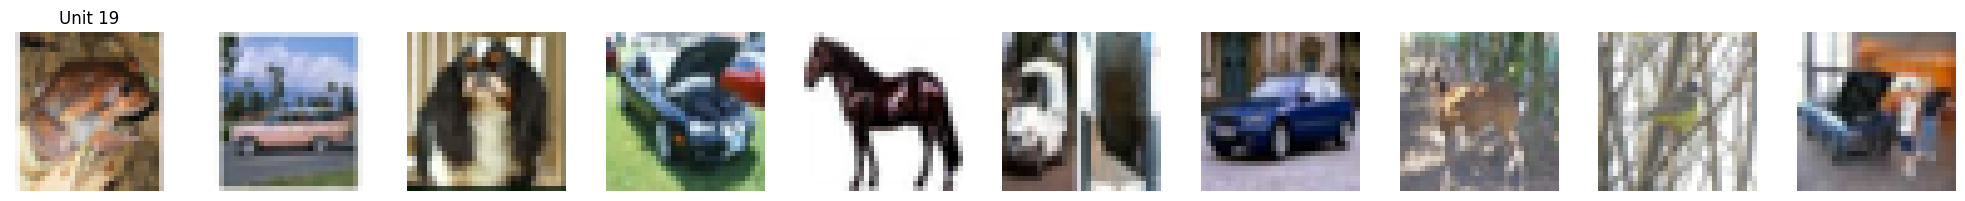

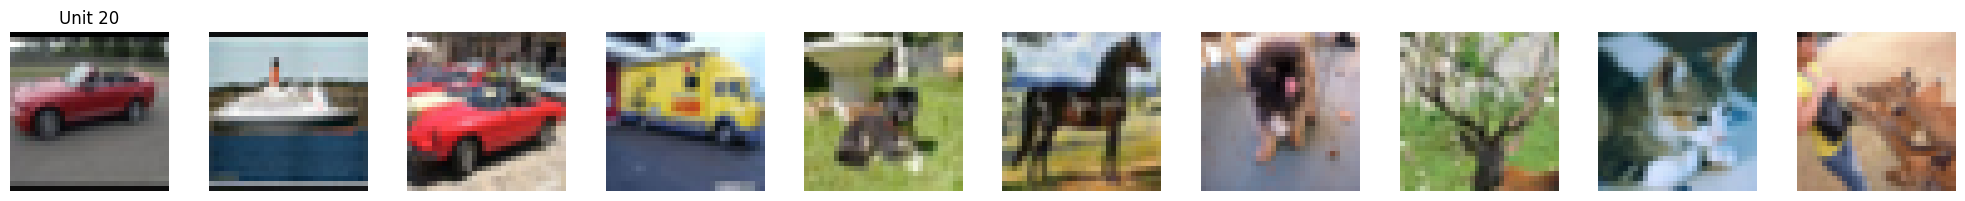

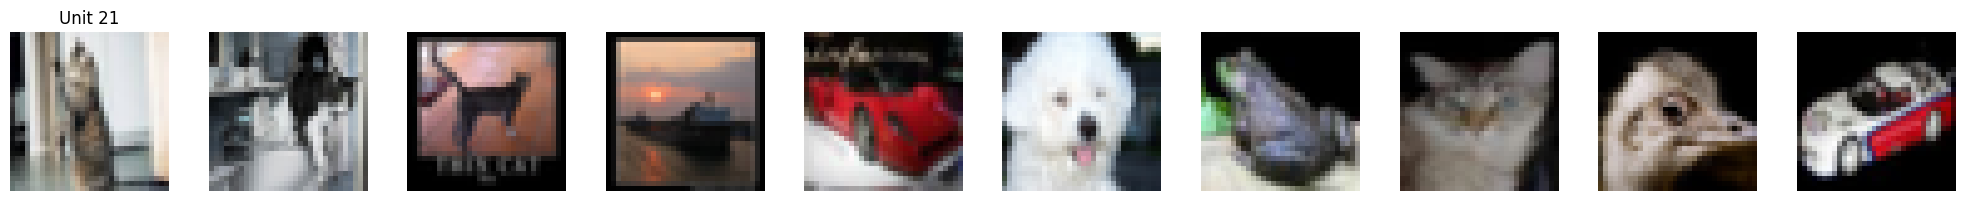

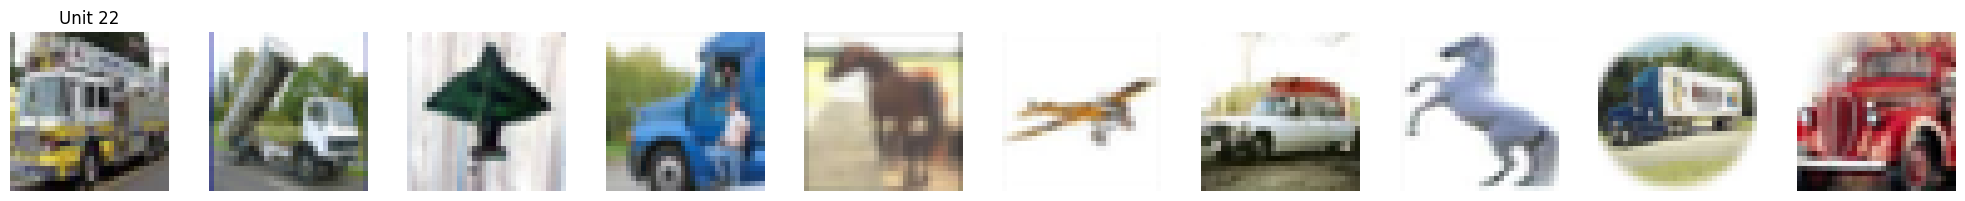

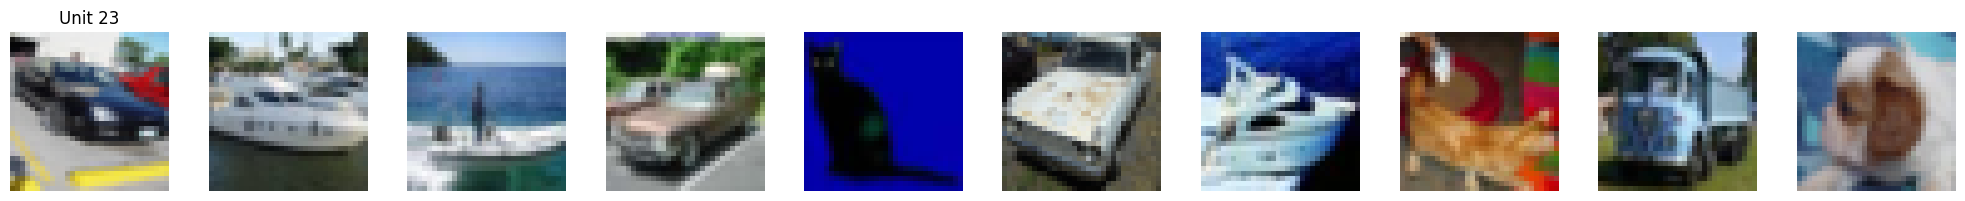

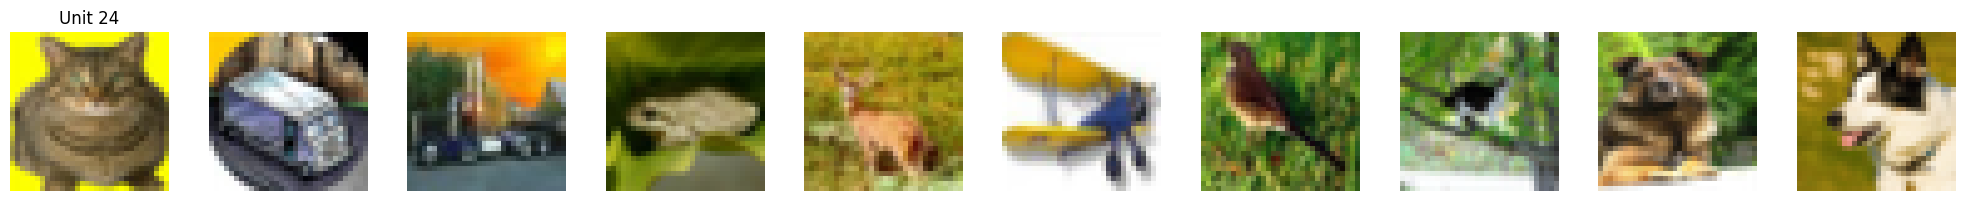

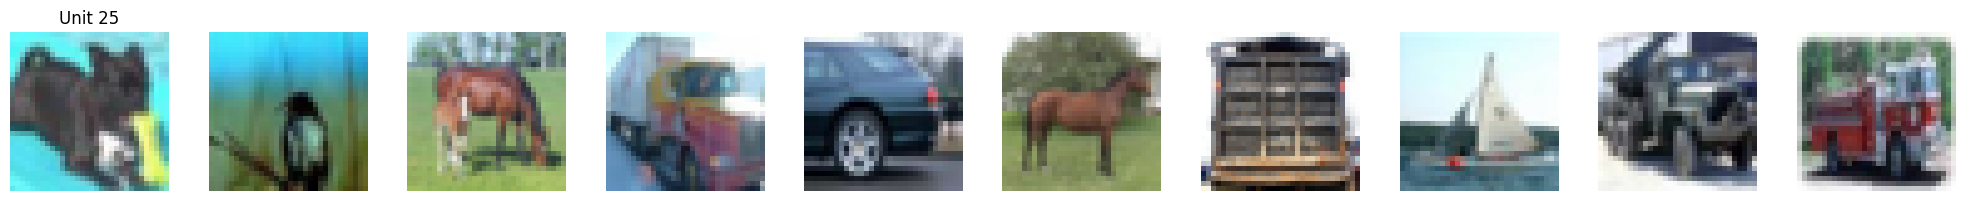

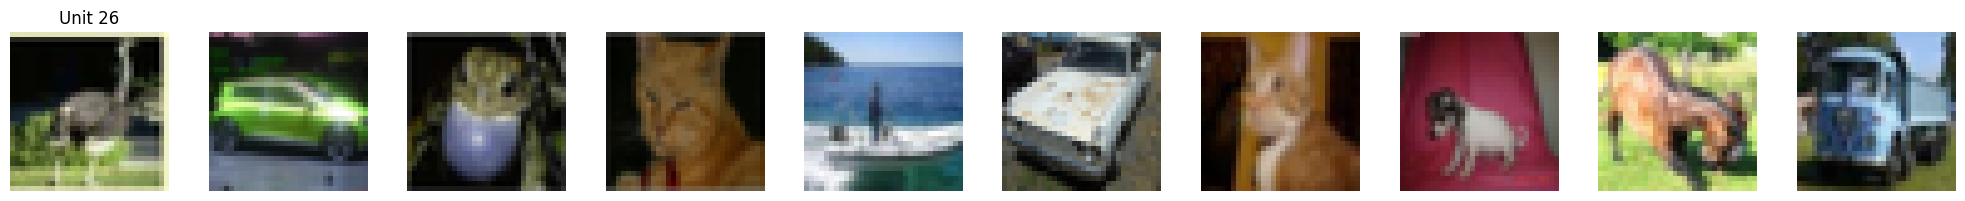

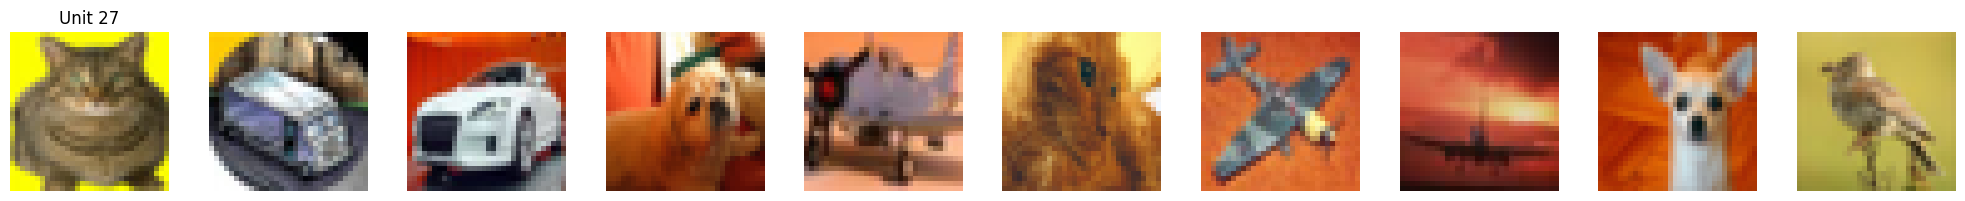

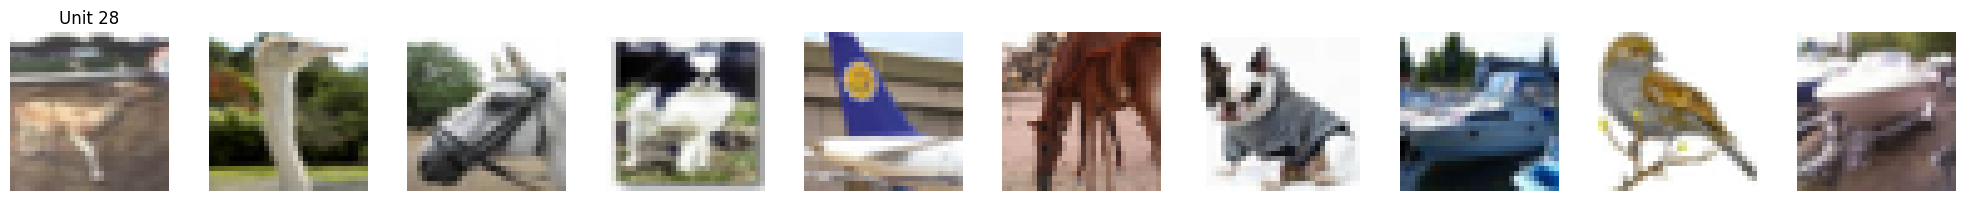

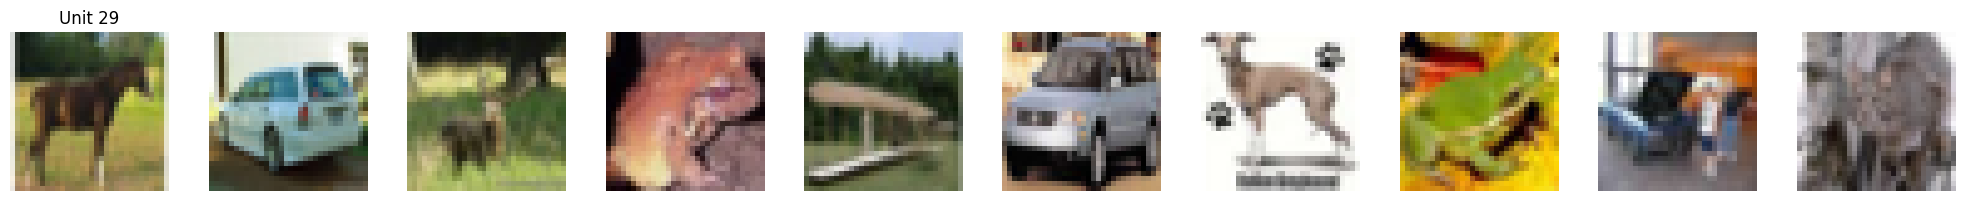

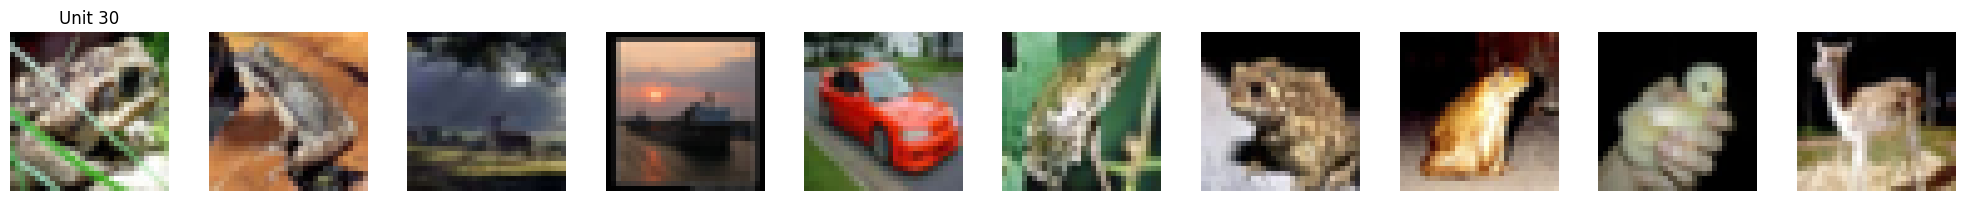

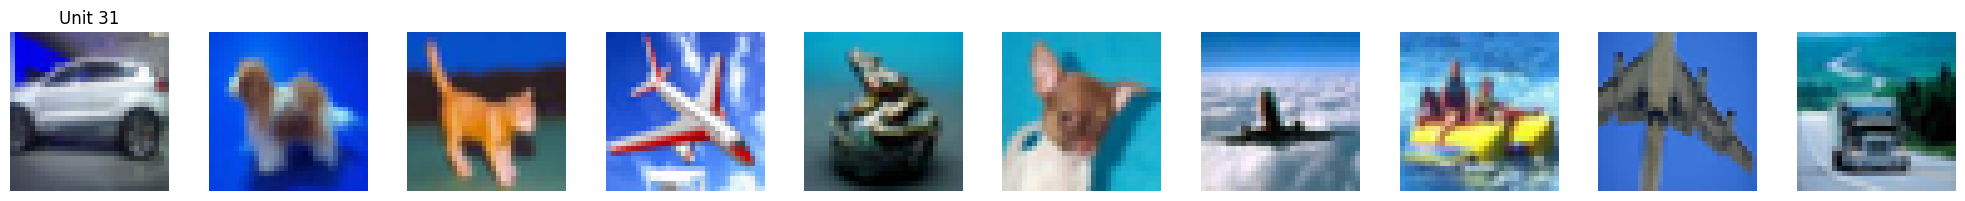

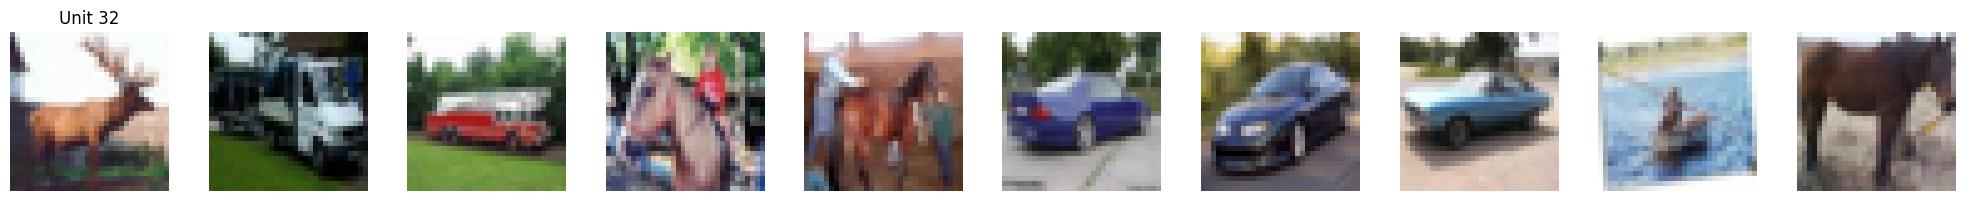

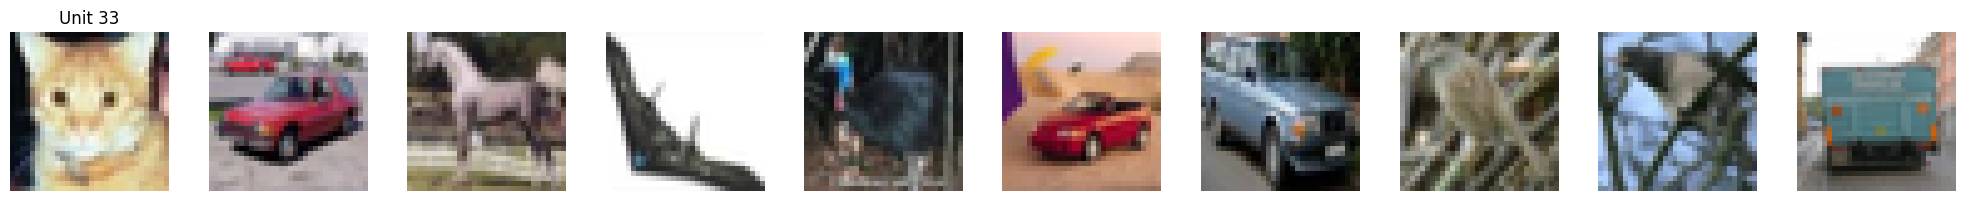

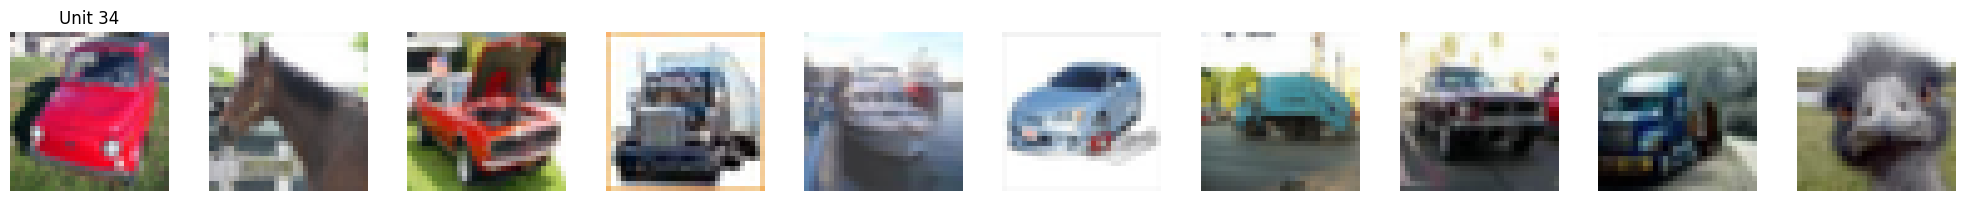

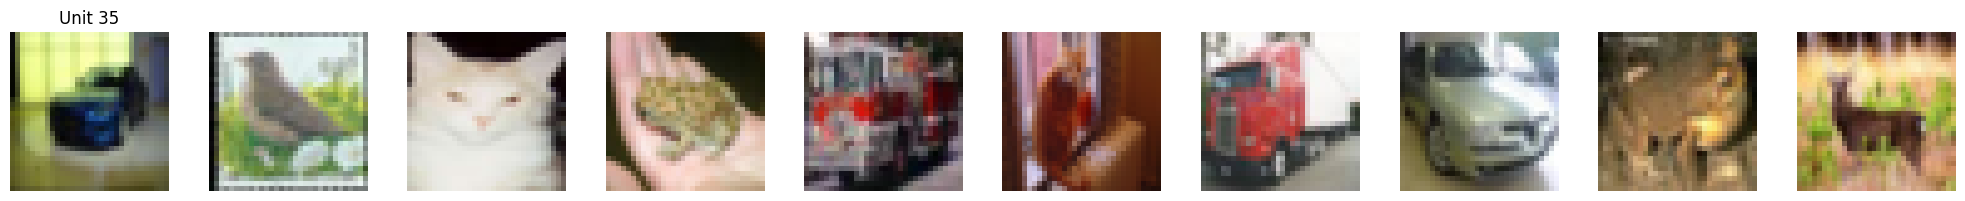

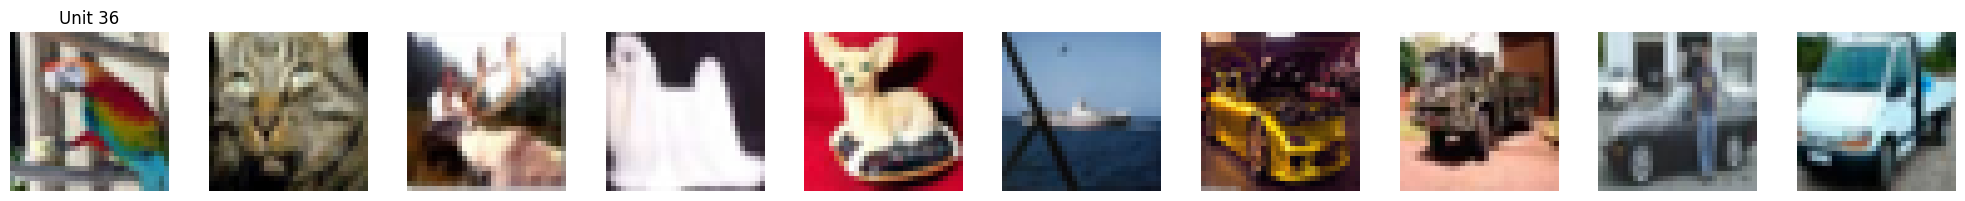

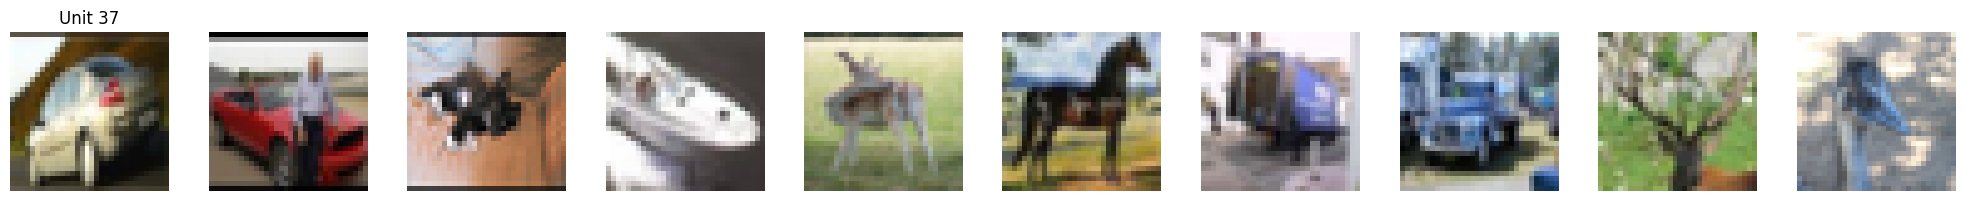

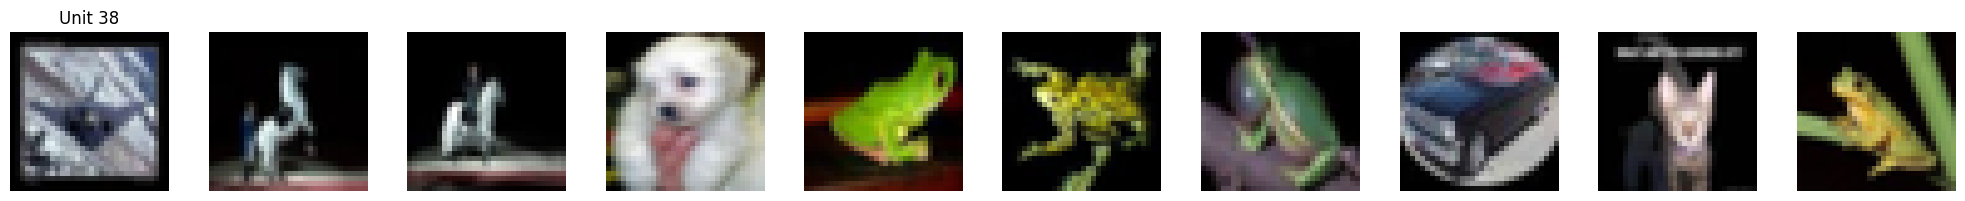

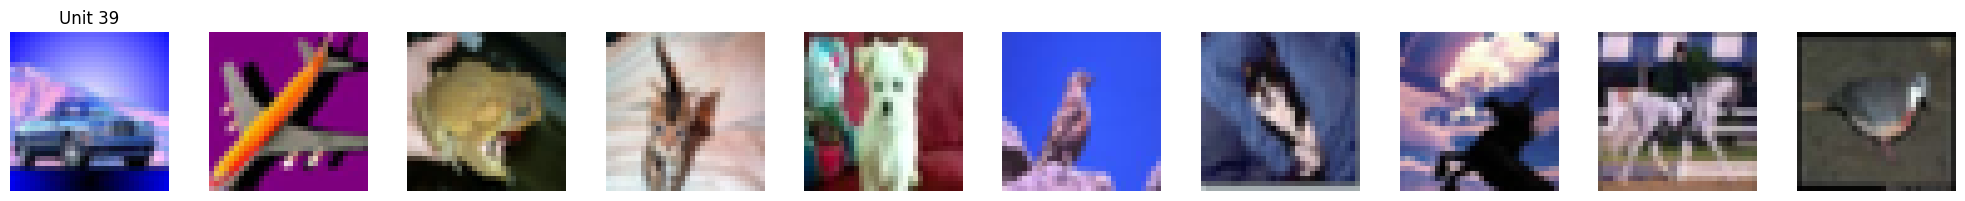

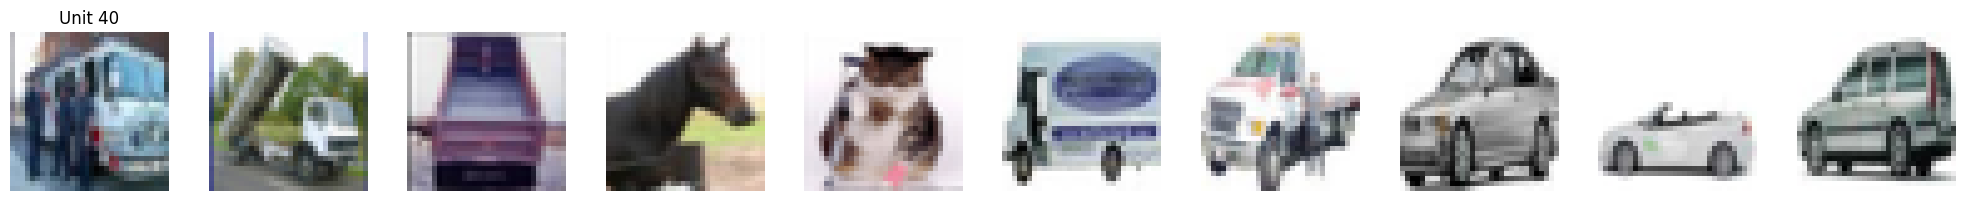

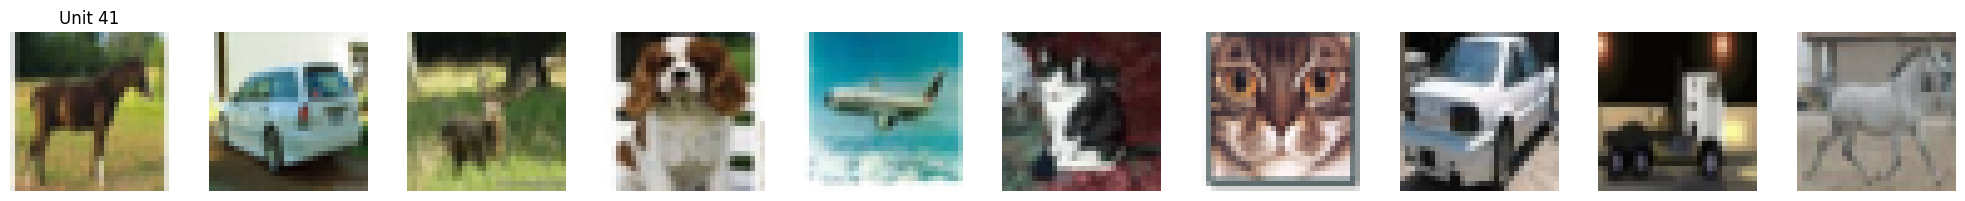

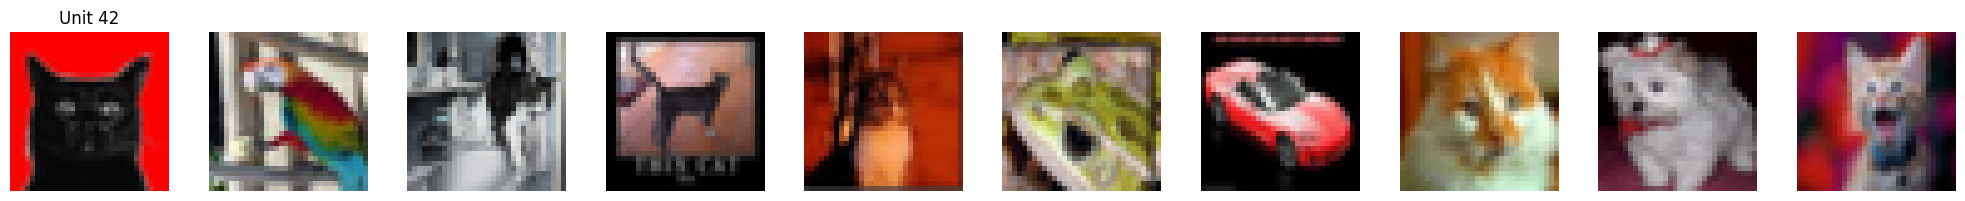

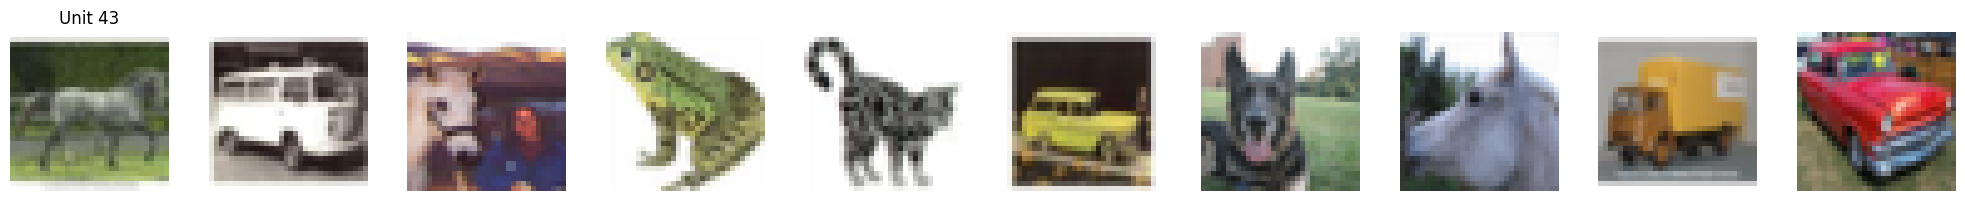

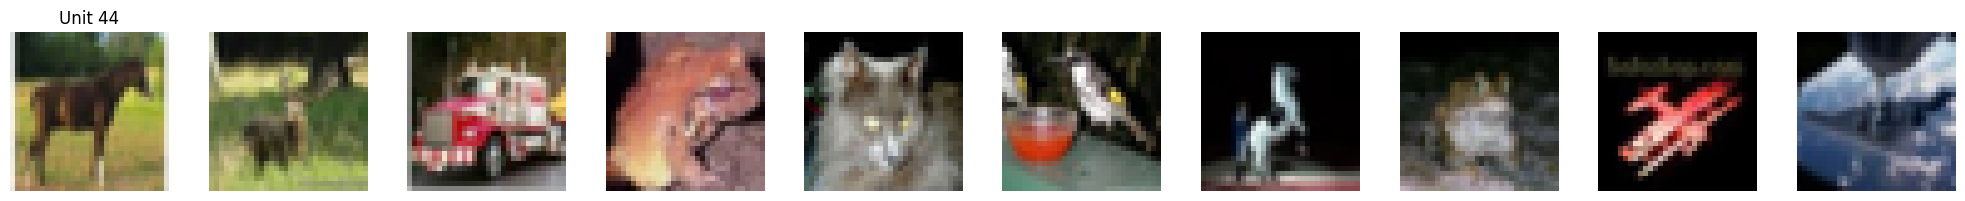

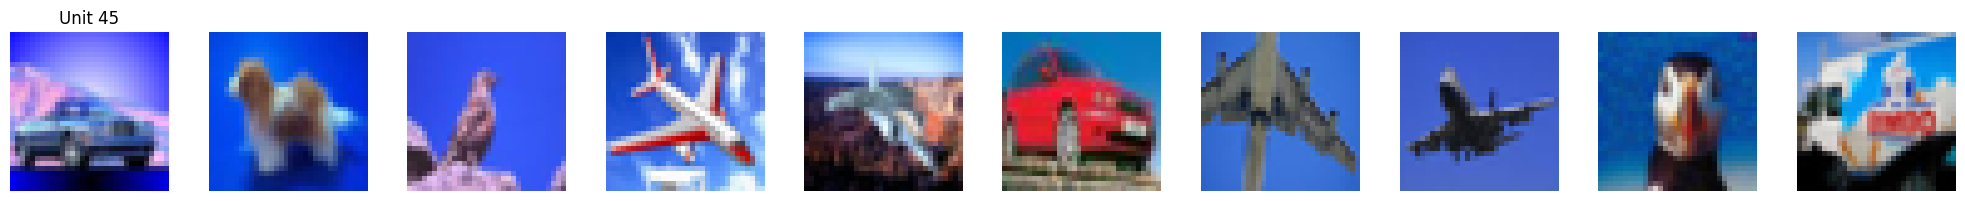

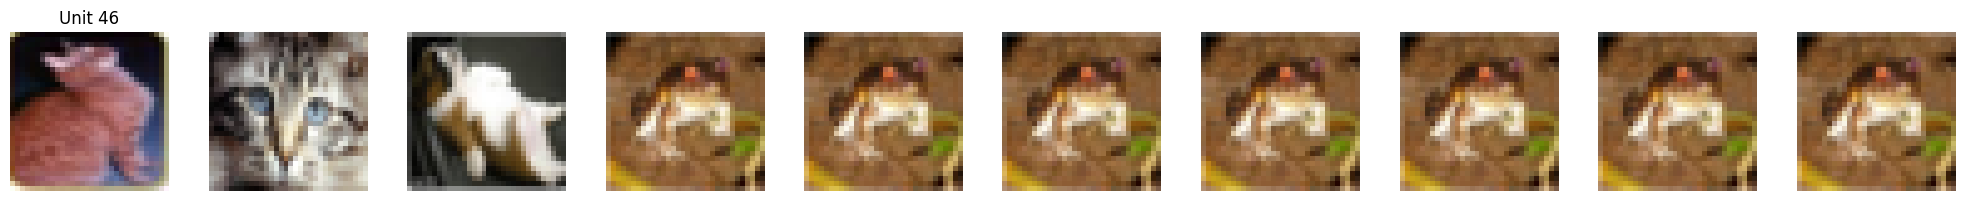

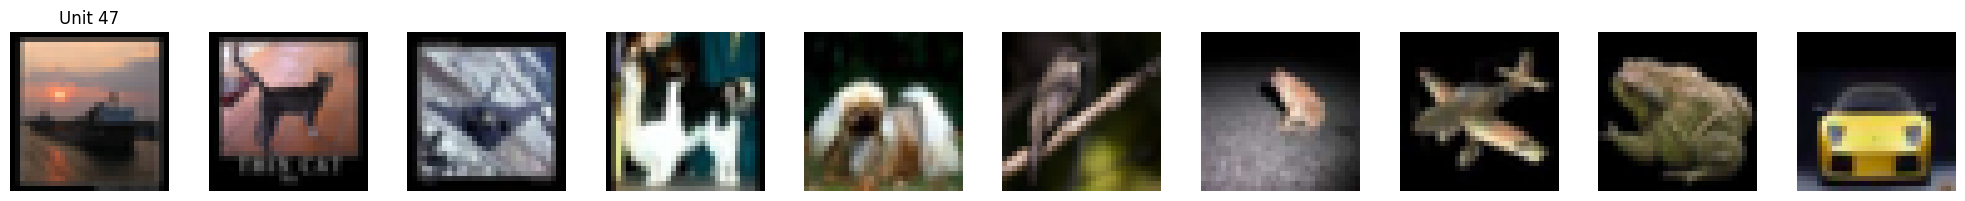

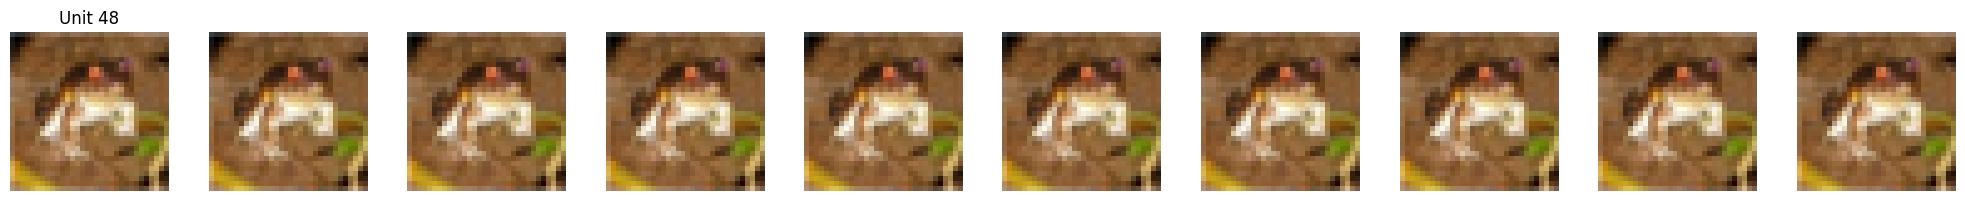

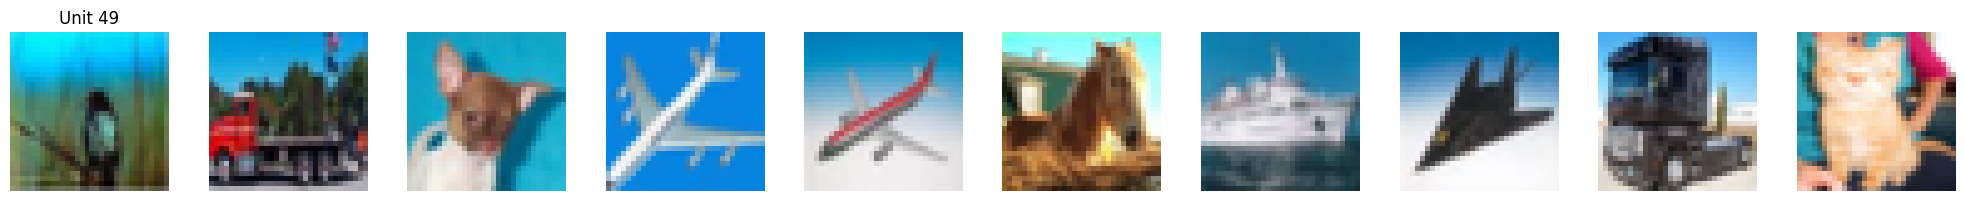

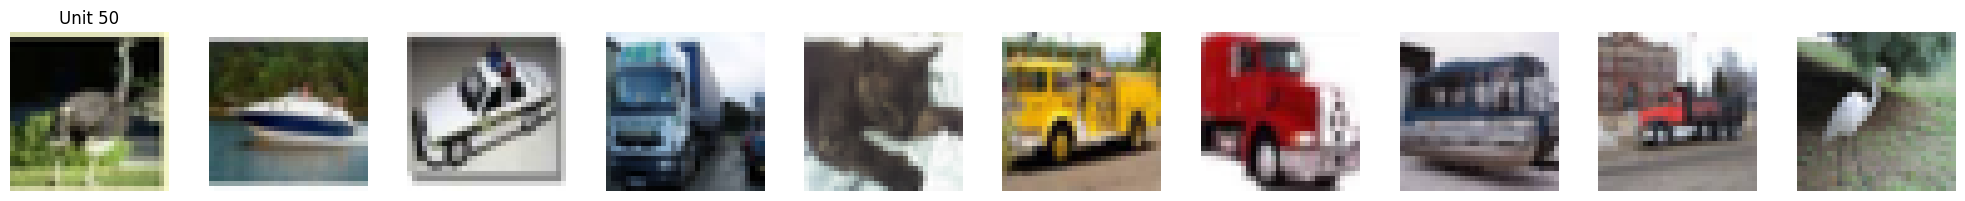

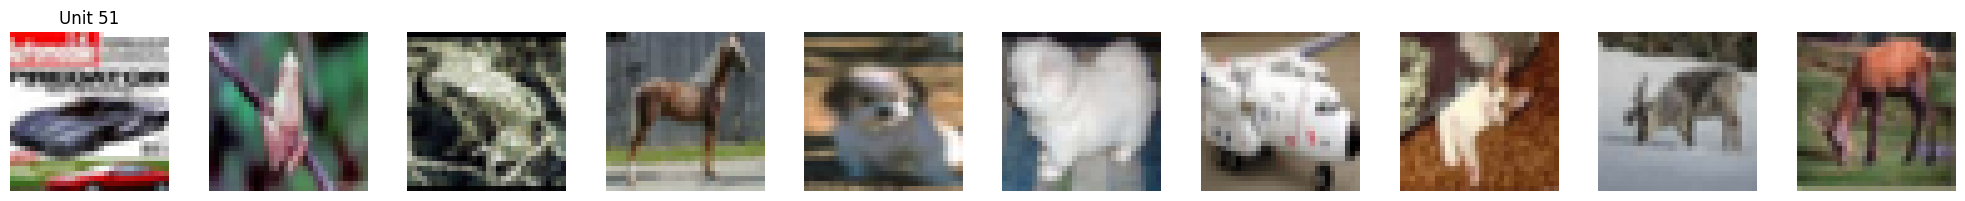

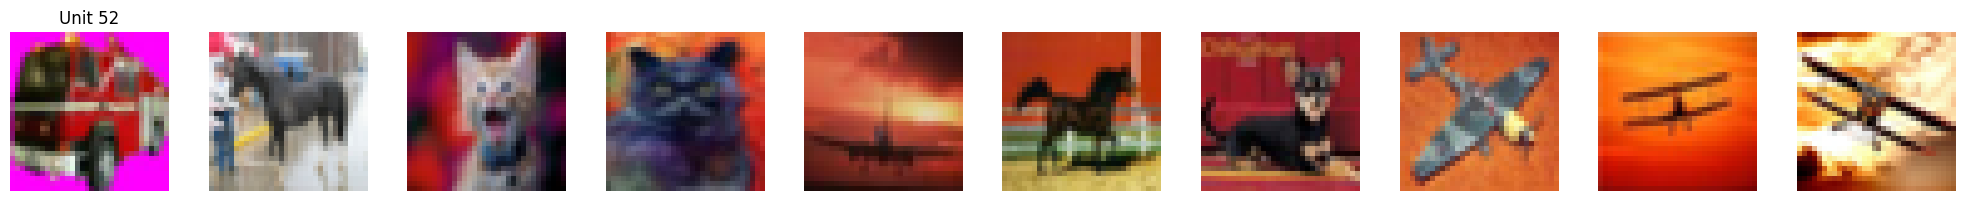

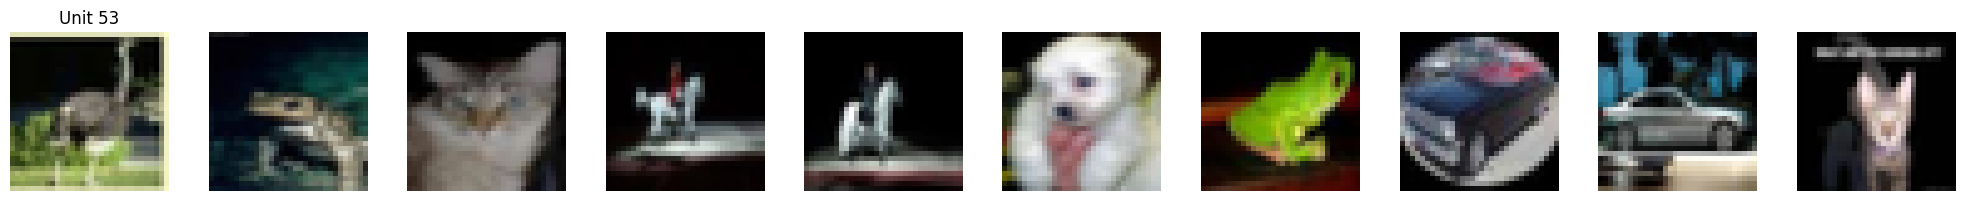

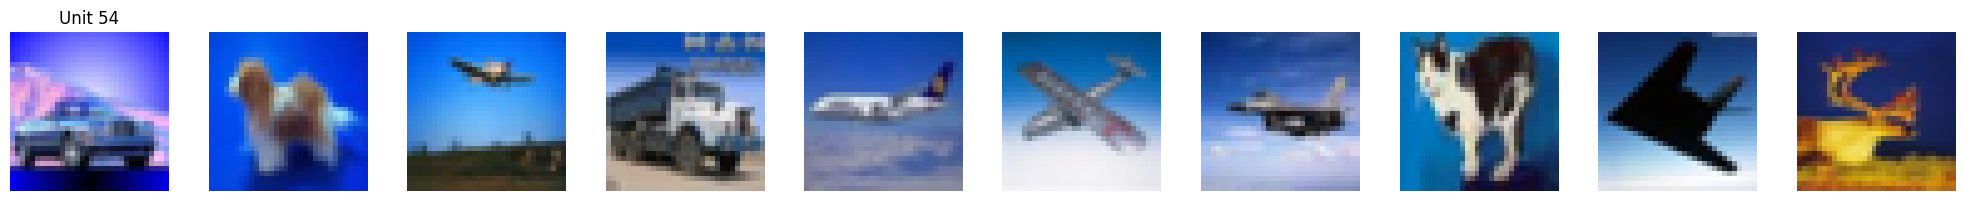

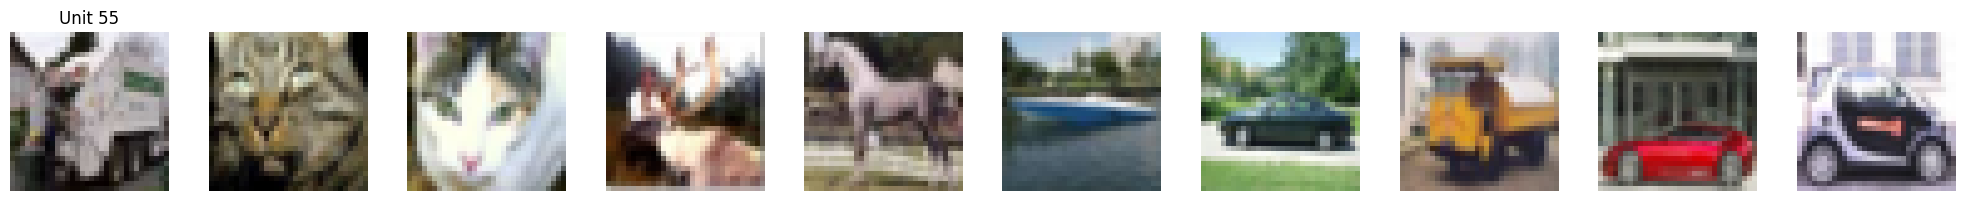

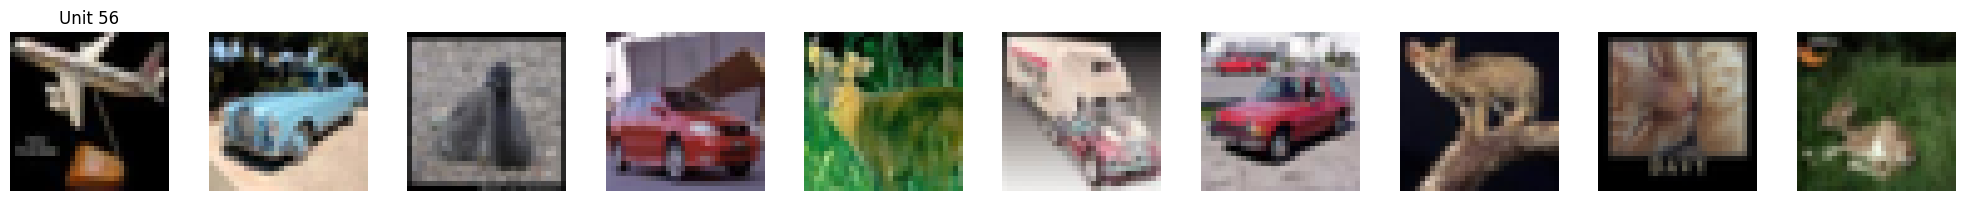

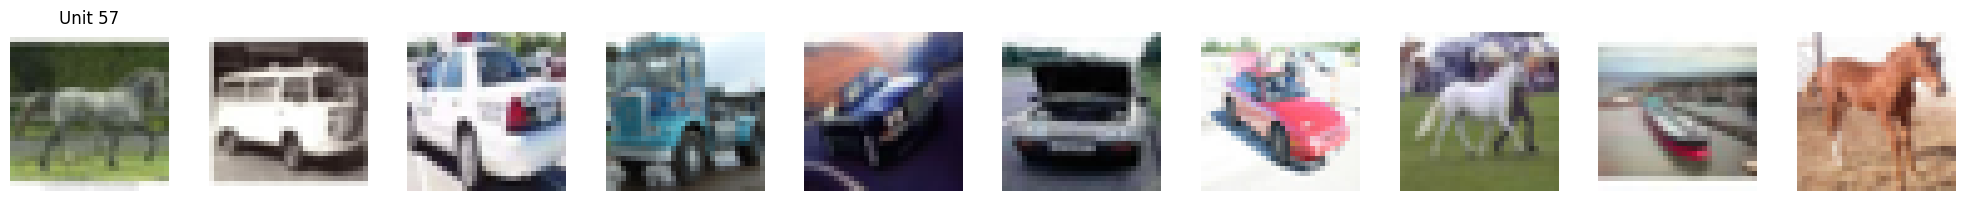

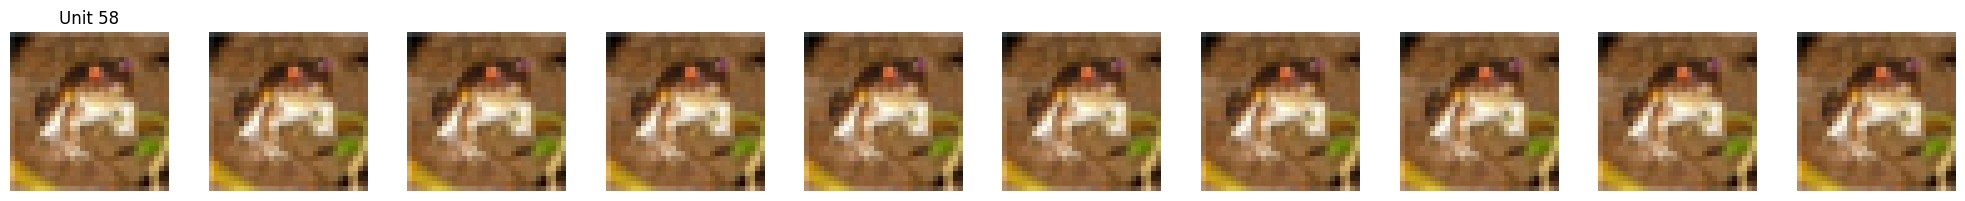

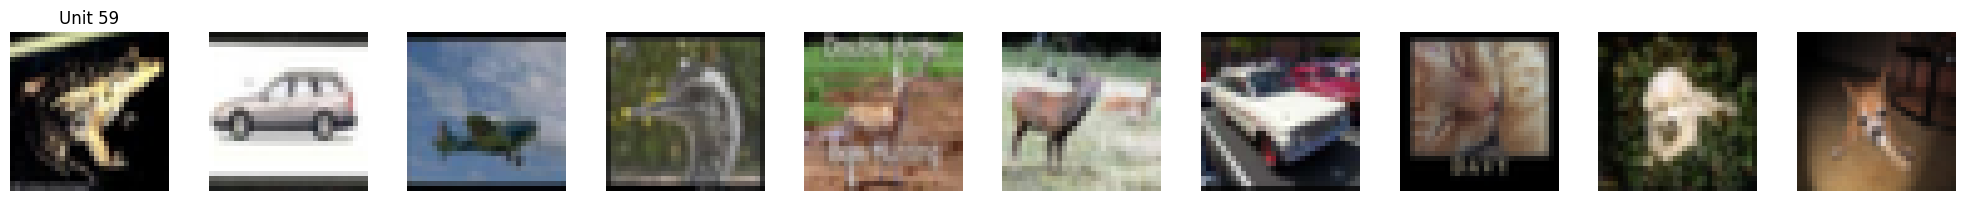

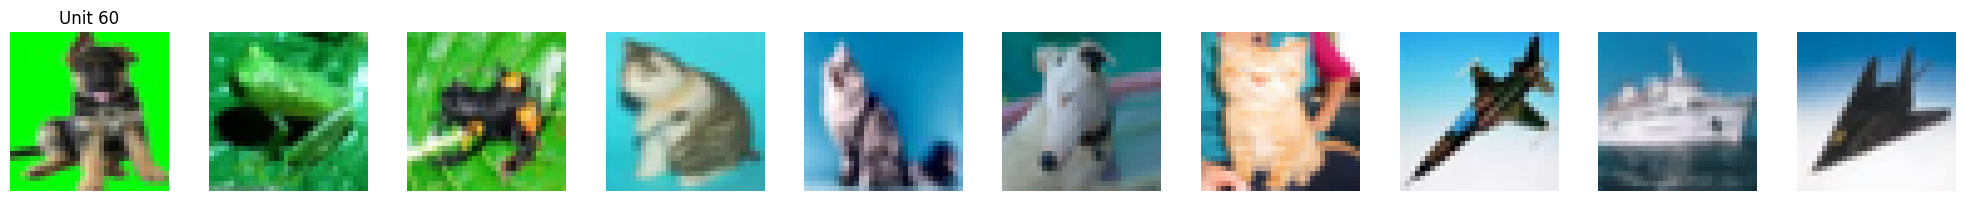

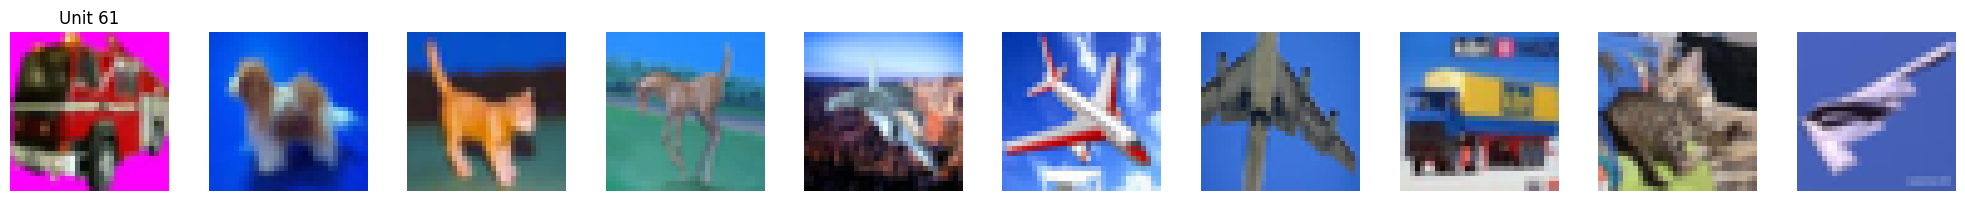

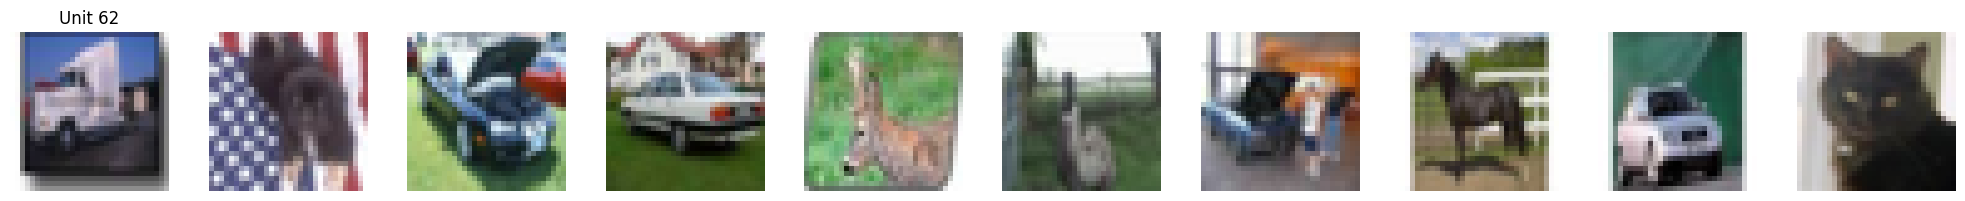

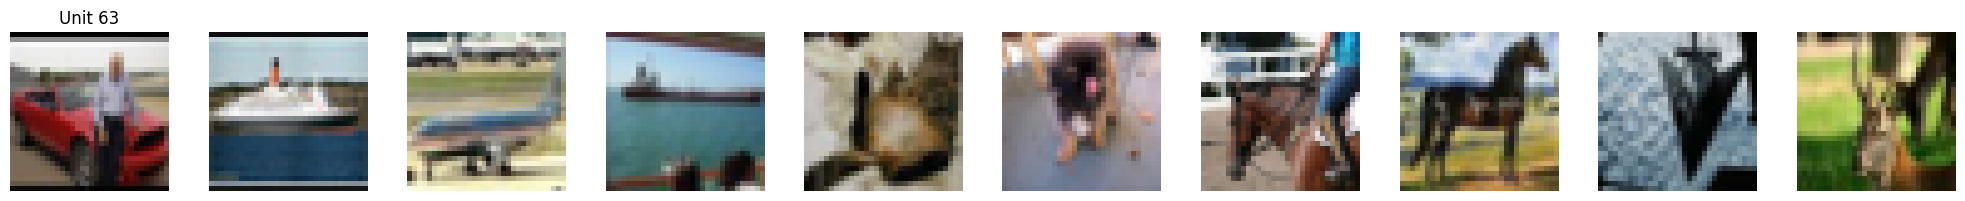

In [ ]:
plot_top_k_images_per_unit(train_data, top_k_indices)

In [ ]:
# Define CIFAR-10 class names
cifar10_class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
                       "Dog", "Frog", "Horse", "Ship", "Truck"]

vgg16_model_full = VGG16(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 12s 0us/step


In [ ]:
[layer.name for layer in vgg16_model_full.layers]

['input_3',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool',
 'flatten',
 'fc1',
 'fc2',
 'predictions']

Processing layer: fc1
32/32 [==============================] - 16s 205ms/step


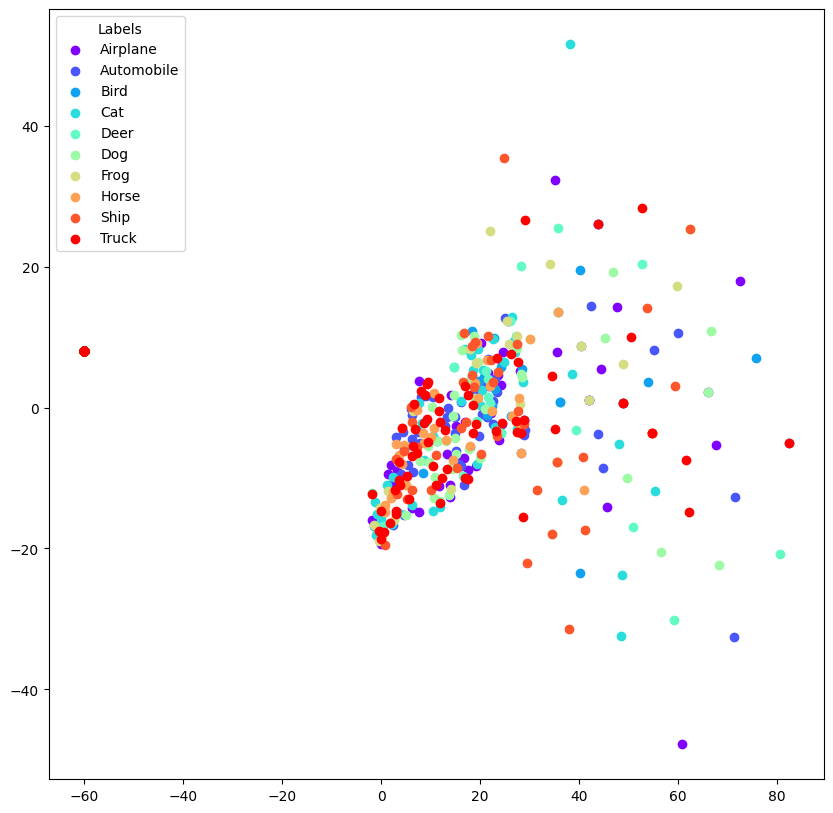

Processing layer: fc2
32/32 [==============================] - 4s 115ms/step


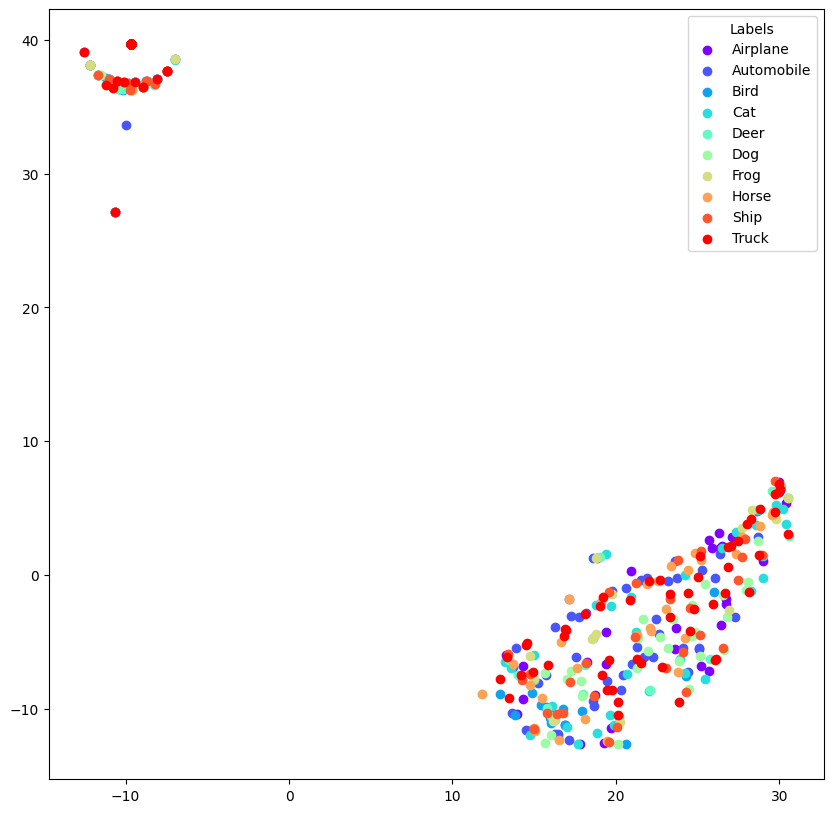

In [ ]:
# Sample a subset of your data
num_samples = 1000  # Adjust this number based on your RAM capacity
subset_data, subset_labels = sample_subset(train_data, train_labels, num_samples)

subset_data_resized = np.array([img_to_array(array_to_img(im, scale=False).resize((224, 224))) for im in subset_data])


for layer in vgg16_model_full.layers:
    if 'fc' in layer.name:  # Check if the layer is a Dense layer
        print(f"Processing layer: {layer.name}")
        # Get activations for the subset
        activations = get_activations(vgg16_model_full, layer.name, subset_data_resized)
        # t-SNE plot for the current layer
        tsne_plot_activations(activations, subset_labels, cifar10_class_names)